## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from os.path import abspath, dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns   
sns.set_style("whitegrid")
import dcor

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [4]:
DEEPREPVIZ_BACKEND = abspath( "../../../Deep-confound-control-v2/application/backend/deep_confound_control/core/")
assert os.path.isdir(DEEPREPVIZ_BACKEND) and os.path.exists(DEEPREPVIZ_BACKEND+'/DeepRepVizBackend.py'), f"No DeepRepViz repository found in {DEEPREPVIZ_BACKEND}. Add the correct relative path to the backend to the 'DEEPREPVIZ_BACKEND' global variable."
if DEEPREPVIZ_BACKEND not in sys.path:
    sys.path.append(DEEPREPVIZ_BACKEND)
from DeepRepVizBackend import DeepRepVizBackend

In [5]:
N_SAMPLES = 5000
EXP_NAME = 'lblmidr-consite'

In [6]:
SHOW_ACCURACIES = True
SHOW_DATASETS_DISTS = False
SHOW_DATASETS_IMAGES = False
SHOW_DATASETS_CORRS = False

RUN_PCA=False
RUN_ICA=False
RUN_LDA=False
RUN_CCA=False
RUN_ICCon=True

## Compute all metrics (DL-act-based $A_{conf}$ scores)

```bash
! python3 run-deeprepvizbackend.py
```
with correct configurations set inside the `run-deeprepvizbackend.py` file

## Load Logdirs using DRV

In [7]:

def lognames_sortrank(logname):
    cy = int(logname.split('cy')[-1].split('-')[0])
    cX = int(logname.split('cX')[-1].split('-')[0])
    yX = int(logname.split('yX')[-1].split('_')[0])
    # sort the index by 100 times (X<-y) signal + 0.5 times (X<-c * c->y) signal
    rank = 100*yX + cX*cy/100
    return rank

In [8]:
# select the model runs for which we want to compare the results
cy = '*'
cX = '*'
yX = '*'
exclude = ['debug']
def check_excludes(str, excludes_list):
    for exclude in excludes_list:
        if exclude in str:
            return False
    return True

logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if check_excludes(log, exclude)]
        )))

print("Collected n={} model logs:".format(len(logdirs)))
# drop log folders that have not been reduced to 3D representations
# logdirs = [logdir for logdir in logdirs if len(glob(f"{logdir}/*/deeprepvizlog/DeepRepViz-v1*"))==len(glob(f"{logdir}/*/deeprepvizlog/"))]
# print("after dropping incomplete logs n={} logs are still remaining".format(len(logdirs)))
    
logdirs = sorted(logdirs, key=lambda l: lognames_sortrank(l))
print("Final list of selected logdirs:")
logdirs

Collected n=75 model logs:
Final list of selected logdirs:


['log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy050-cX050-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f003',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f064',
 'log/toybrains_n5000_lblmidr-consite_cy075-cX075-yX000_SimpleCNN_c1-f256',
 'log/toybrains_n5000_lblmidr-consite_cy100-cX100-yX000_SimpleCNN_c1-f003',
 'log/toybra

In [9]:
# parallelize the loading of the logs
def process_drvlogdir(deeprepvizlogdir, verbose=1):
    if verbose>=1: print("loading from:", deeprepvizlogdir)

    iter_version = basename(dirname(deeprepvizlogdir))
    if verbose>=1: print("loading run version:", iter_version)
    # ignore the missing conf_table warning from DeepRepVizBackend
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Provided conf_table")
        drv_backend = DeepRepVizBackend(best_ckpt_by='loss_val')
    drv_backend.load_log(deeprepvizlogdir)

    log = drv_backend.deeprepvizlogs[deeprepvizlogdir]
    ckpt_idx = log['best_ckpt_idx']
    ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
    logdirname = deeprepvizlogdir.split('/')[-3]
    dataset = logdirname.split('_')[3]
    model_name = logdirname.replace(dataset, '').split('__')[-1]
    if verbose>=2:
        print(f"{'='*100}\n {model_name} :: \n\t setting: {dataset} ")
        print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
        print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()}))
        
    result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
    if 'act_metrics' not in log_ckpt:
        print(f"[WARN] Metrics not computed for {logdirname}/{iter_version} at ckpt={ckptname} (idx={ckpt_idx}). Not aggregating metrics...")
        
    else:
        for metric_name, metric_scores in log_ckpt['act_metrics'].items():
            if verbose>=2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
            for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
                if verbose: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
                result.update({(key, metric_name): metric_scores[key]})

    ### (2) load the activation at the best checkpoints of the given model
    act = log['checkpoints'][ckpt_idx][1]['acts']
    test_acc = log['checkpoints'][ckpt_idx][1]['metrics']['BAC_test']
    best_ckpt_tensors = {
        'best_ckpt_idx': log['best_ckpt_idx'],
        'IDs': log['IDs'],
        'y': log['labels'].astype(float),
        'test_acc': test_acc,
        'act': act,
        'y_pred': log['checkpoints'][log['best_ckpt_idx']][1]['preds_0'].astype(float),
        'y_pred_weights': log['checkpoints'][log['best_ckpt_idx']][1]['weights_0'], 
        'y_pred_biases': log['checkpoints'][log['best_ckpt_idx']][1]['biases_0'],
        
    }
    if verbose>=1: print(f"activation loaded with shape {act.shape}")

    return (dataset, model_name, iter_version, best_ckpt_tensors), result

In [10]:
# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, verbose=1, n_jobs=-1):

    # for each logdir extract the list of all runs
    logdirs_runs = []
    for logdir in logdirs:
        logdirs_runs.extend(sorted(glob(f"{logdir}/*/deeprepvizlog")))

    all_results_drvs = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(process_drvlogdir)(drvlogdir, verbose) for drvlogdir in tqdm(logdirs_runs))
    
    if len(all_results_drvs)==0:
        print("[ERROR] No results were loaded. Exiting...")
        return None

    # sort them by the dataset name first by yX
    all_results_drvs = sorted(all_results_drvs, key= lambda logs: lognames_sortrank(logs[0][0]))

    ### combine all the results into one dataframe
    all_results = {(d,m,v): result_row for (d,m,v, tensors), result_row in all_results_drvs}
    
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['dataset', 'model_name', 'trial'])
    # sort the rows: by dataset then within it by trial
    df_results = df_results.sort_index(level='trial').sort_index(level=0, # 'dataset'
                                       key=np.vectorize(lognames_sortrank))
    # reorder the columns: multi-index to first have the model name and then the metric name
    df_results = df_results.sort_index(axis='columns', level=[0,1])
    
    ### collect the tensors into another list 
    logs = [(d,m,v, tensors) for (d,m,v, tensors), _ in all_results_drvs]
    
    return df_results, logs


#################################################################################################################
df_results, logs = collect_deeprepviz_results(logdirs, verbose=0, n_jobs=10)

  0%|          | 0/225 [00:00<?, ?it/s]

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f003/trial_0 at ckpt=epoch09-step000200 (idx=4). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f003/trial_0 at ckpt=epoch07-step000160 (idx=5). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f003/trial_2 at ckpt=epoch17-step000360 (idx=7). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f064/trial_2 at ckpt=epoch03-step000080 (idx=3). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX000_SimpleCNN_c1-f003/trial_1 at ckpt=epoch05-step000120 (idx=4). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy025-cX025-yX000_SimpleCNN_c1-f003/trial_2 at ckpt=epoch06-step000140 (idx=3). N

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX050_SimpleCNN_c1-f003/trial_1 at ckpt=epoch17-step000360 (idx=9). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX025_SimpleCNN_c1-f256/trial_2 at ckpt=epoch56-step001140 (idx=19). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX050_SimpleCNN_c1-f003/trial_2 at ckpt=epoch17-step000360 (idx=11). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX025_SimpleCNN_c1-f256/trial_2 at ckpt=epoch02-step000060 (idx=2). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX025_SimpleCNN_c1-f256/trial_0 at ckpt=epoch18-step000380 (idx=10). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX025_SimpleCNN_c1-f256/trial_1 at ckpt=epoch27-step000560 (idx=11

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX050_SimpleCNN_c1-f064/trial_1 at ckpt=epoch11-step000240 (idx=7). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX050_SimpleCNN_c1-f064/trial_0 at ckpt=epoch33-step000680 (idx=16). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX025_SimpleCNN_c1-f256/trial_1 at ckpt=epoch81-step001640 (idx=36). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX025_SimpleCNN_c1-f256/trial_2 at ckpt=epoch72-step001460 (idx=24). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX050_SimpleCNN_c1-f064/trial_2 at ckpt=epoch73-step001480 (idx=30). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX050_SimpleCNN_c1-f003/trial_1 at ckpt=epoch28-step000580 (idx=7

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX050_SimpleCNN_c1-f064/trial_0 at ckpt=epoch06-step000140 (idx=4). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX050_SimpleCNN_c1-f064/trial_1 at ckpt=epoch10-step000220 (idx=5). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX050_SimpleCNN_c1-f064/trial_2 at ckpt=epoch03-step000080 (idx=3). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX050_SimpleCNN_c1-f256/trial_1 at ckpt=epoch32-step000660 (idx=14). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX075_SimpleCNN_c1-f003/trial_0 at ckpt=epoch27-step000560 (idx=10). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX050_SimpleCNN_c1-f064/trial_2 at ckpt=epoch41-step000840 (idx=21)

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX100_SimpleCNN_c1-f003/trial_2 at ckpt=epoch56-step001140 (idx=28). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy000-cX000-yX100_SimpleCNN_c1-f256/trial_0 at ckpt=epoch20-step000420 (idx=12). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX100_SimpleCNN_c1-f064/trial_1 at ckpt=epoch20-step000420 (idx=10). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX100_SimpleCNN_c1-f064/trial_0 at ckpt=epoch59-step001200 (idx=20). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX100_SimpleCNN_c1-f064/trial_2 at ckpt=epoch12-step000260 (idx=9). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX075_SimpleCNN_c1-f256/trial_0 at ckpt=epoch54-step001100 (idx=2

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX100_SimpleCNN_c1-f064/trial_2 at ckpt=epoch11-step000240 (idx=6). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy050-cX050-yX100_SimpleCNN_c1-f256/trial_1 at ckpt=epoch17-step000360 (idx=14). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy025-cX025-yX100_SimpleCNN_c1-f256/trial_0 at ckpt=epoch48-step000980 (idx=26). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy075-cX075-yX100_SimpleCNN_c1-f256/trial_0 at ckpt=epoch31-step000640 (idx=16). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX100_SimpleCNN_c1-f256/trial_0 at ckpt=epoch09-step000200 (idx=4). Not aggregating metrics...
[WARN] Metrics not computed for toybrains_n5000_lblmidr-consite_cy100-cX100-yX100_SimpleCNN_c1-f256/trial_2 at ckpt=epoch12-step000260 (idx=8)

In [57]:
unique_models = sorted(list(set([model for _, model, _, _ in logs])))
unique_datasets = sorted(list(set([dataset for dataset, _, _, _ in logs])), key=lambda x: lognames_sortrank(x))

## Show Accuracies

In [12]:
if SHOW_ACCURACIES:
    print("loaded {} rows with {} models, {} unique datasets per model with upto {} trials per dataset.".format(len(df_results), 
                                            (df_results.index.get_level_values('model_name').nunique()), 
                                            (df_results.index.get_level_values('dataset').nunique()), 
                                            (df_results.index.get_level_values('trial').nunique())))

    # show the table
    # display(df_results.style.bar(vmin=0, vmax=1))

loaded 225 rows with 3 models, 25 unique datasets per model with upto 3 trials per dataset.


See average values across trials

In [13]:
if SHOW_ACCURACIES:
    # display the average performances across trials for all datasets and all models
    display(df_results.reset_index().groupby(['dataset']).mean(numeric_only=True).style.bar(vmin=0, vmax=1))

dropping on a non-lexsorted multi-index without a level parameter may impact performance.


### Plot the results

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


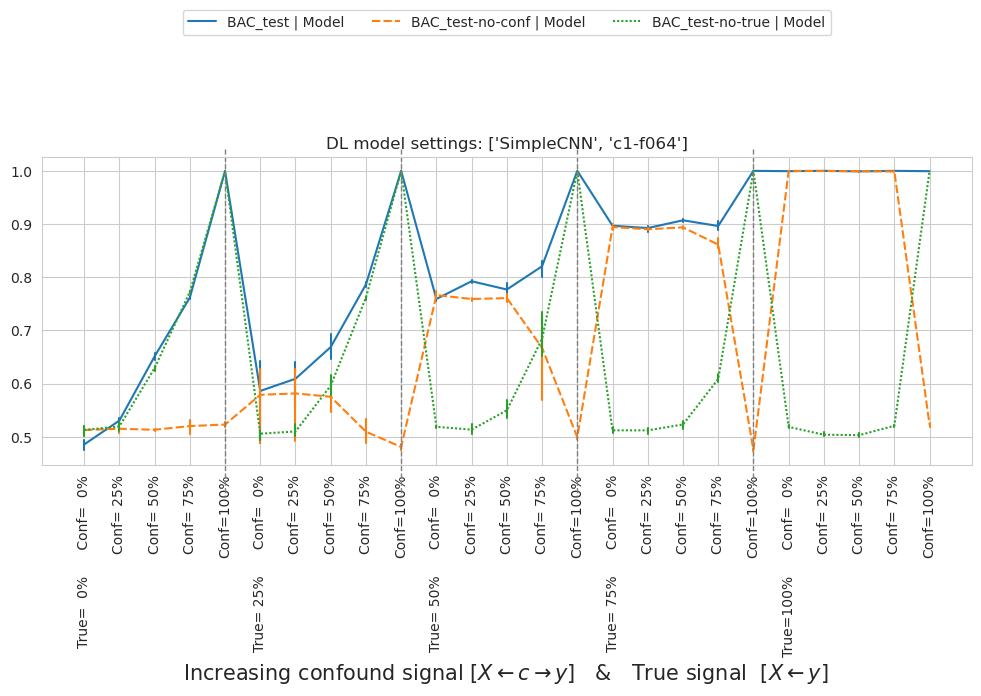

In [14]:
def plot_deeprepviz_results(df_results, 
                            filter = '.*',
                            norm_metrics = '', #'dcor|mi|con|r2',
                            model_name_filter='.*',
                            ylim = None):
    df = df_results.copy()
    # flatten the multi-index columns
    df.columns = [' | '.join(col[::-1]).strip() for col in df.columns.values]

    original_cols = list(df.columns)
    # drop the loss columns
    df = df.filter(regex='^(?!.*loss.*)')
    # drop the costeta columns
    df = df.filter(regex='^(?!.*costeta)')
    # apply other user-provided column filters
    df = df.filter(regex=filter)
    assert len(df.columns) != 0, f"No columns remained after applying the filter: {filter} out of the orignal:\n{original_cols}"

    # drop the loss
    # df = df.drop(columns=[('model_name', ''),('trial', ''), *loss_cols])
    # sort the final columns alphabetically
    df = df.reindex(sorted(df.columns), axis='columns')
    # drop the indexes 'model_name' and 'trial' and only keep the 'data_setting' as index
    df = df.reset_index(level=['model_name', 'trial'])
    # apply the model type selection filter
    df = df[df['model_name'].str.match(model_name_filter)]

    for feas, dfi in df.groupby('model_name'):

        dfi = dfi.drop(columns=['model_name', 'trial'])
        # normalize the metrics requested
        if norm_metrics != '':
            metric_cols = dfi.columns.str.contains(norm_metrics)
            dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
            lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
        # plot the results
        fig, ax = plt.subplots(figsize=(12, 4))
        g = sns.lineplot(dfi, err_style="bars", ax=ax)
        sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        
        ax.set_title(f"DL model settings: {feas.split('_')}")
        if ylim is not None or norm_metrics!='': ax.set_ylim(ylim)

        # on the x-axis ticks show the total correlation X<-y and the total X<-c->y
        # new_xticklabels = ax.get_xticklabels()
        new_xticklabels = []
        majorticks = []
        last_Xy = -1
        last_Xcy = -1
        for lbl in ax.get_xticklabels():
            cy, cX, yX  = lbl.get_text().split('-')
            cy = int(cy[-3:])
            cX = int(cX[-3:])
            yX = int(yX[-3:])
            total_Xy = yX
            total_Xcy = (cX*cy)**(1/2)                

            if total_Xy != last_Xy:
                new_xticklabels.append(f'True={total_Xy:3.0f}%      Conf={total_Xcy:3.0f}%')
                last_Xy = total_Xy
                # add a major tick label every time the total_Xy changes
                majorticks.append(lbl.get_position()[0]-1)
            else:
                new_xticklabels.append(f'Conf={total_Xcy:3.0f}%')
        
        ax.xaxis.set_ticklabels(new_xticklabels, rotation=90)
        # vertical lines to show transition of X<-c->y
        for x_line in majorticks:
            if x_line>0:
                ax.vlines(x_line, ax.get_ylim()[-1], -0.1, color='grey', ls='--', lw=1,
                        clip_on=False, transform=ax.get_xaxis_transform())
        # ax.set_xlim(-0.1, majorticks[-1]+1)

        ax.set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    
        plt.show()


#############################################################################################################
if SHOW_ACCURACIES:
    plot_deeprepviz_results(df_results, filter='BAC_test.*Model.*',  
                            model_name_filter='.*c1-f064',
                            norm_metrics='')

## New metrics: CCA / PCA / ICA

In [15]:
# logdir_runs =([l for logdir in logdirs for l in glob(f"{logdir}/*/deeprepvizlog")])
# logdir_runs = sorted(logdir_runs, key=lambda l: lognames_sortrank(l.split('/')[-3]))
# logdir_runs

### Load activations $H^{(l-1)}$ for all trials

#### Datasets distributions

In [60]:
from utils.vizutils import plot_col_dists, plot_col_counts, show_images

if SHOW_DATASETS_IMAGES or SHOW_DATASETS_DISTS or SHOW_DATASETS_CORRS:

    for dataset_cy_cx_yx in unique_datasets:
        
        dataset_log = 'Dataset: '+ dataset_cy_cx_yx
        print('--'*80, '\n', dataset_log)
        dataset_name = f'dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset_cy_cx_yx}'
        df = pd.read_csv(f'{dataset_name}/{os.path.basename(dataset_name)}.csv') 
        # drop the volumes(_vol) as radius (_rad) already captures this info
        df = df.drop(columns=df.columns[df.columns.str.contains('vol') & ~(df.columns.str.contains('rad'))])

        ### (1) show the image attributes distributions
        cov_cols = df.filter(regex='^(cov_|lbl_)').columns
        attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
        if SHOW_DATASETS_DISTS:
            plot_col_dists(df, 
                        attr_cols=attr_cols, 
                        cov_cols=cov_cols, 
                        title=f"Distributions of the image attributes after sampling")
            plt.show()

            ### (2) show the label and confounder distributions
            plot_col_counts(df[cov_cols], title="Label & confound dist.:")
            plt.show()

        ### (3) show the correlation between the conf and labels
        if SHOW_DATASETS_CORRS:
            drv = DeepRepVizBackend(conf_table=df, 
                                ID_col='subjectID', label_col='lbl_lesion', 
                                best_ckpt_by="test_loss")
            # colormap diverging from black instead of white
            hue_neg, hue_pos = 250, 15
            cmap = sns.diverging_palette(hue_neg, hue_pos, center="dark", as_cmap=True)

            corr = drv.df_conf.corr()
            # mask out the upper triangle
            mask = np.zeros_like(corr, dtype=bool)
            mask[np.triu_indices_from(mask)] = True
            # vals with very low correlation (|corr|  < 0.01) are masked out too
            mask[(np.abs(corr) < 0.025)] |= True
            # set the masked values to nan so that it will be not displayed using .format(na_rep='')
            corr[mask] = np.nan
            display(corr.style
                        .background_gradient(cmap='copper', axis=None, vmin=0, vmax=1)
                        .format(precision=2, na_rep=''))

        ### (3) show sample images for different combinations of the conf and label states
        if SHOW_DATASETS_IMAGES:
            n_imgs_per_row = 15
            # show 4 rows of images with different combinations of covariate and label states
            # df = pd.read_csv(f'{dataset}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv')
            for (lbl, cov), dfi in df.groupby(['lbl_lesion', 'cov_site']):
                # sample n_imgs_per_row 
                samples = dfi.sample(n_imgs_per_row, replace=False, random_state=None).index.values
                img_files = [f"{dataset_name}/images/{s:05}.jpg" for s in samples]
                # print(lbl, cov, img_files)
                show_images(img_files=img_files,
                            n_cols=n_imgs_per_row, n_rows=1,
                            title=f"{dataset_log}      |      lbl_lesion={lbl}      |       cov_site={cov}      |")
                plt.show()

### $\frac{dCor(\hat{y},c)}{dCor(y,c)}$

In [17]:
def compute_dcor_sq(X, y):
    if len(X.shape)>1: 
        y = y.reshape(-1,1)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    dcor_score = float(dcor.distance_correlation_sqr(X, y))
    return dcor_score**2

In [18]:
# N_COMPONENTS = 3 


# for dataset in unique_datasets:

#     logs_subset = [log for log in logs if (log[0]==dataset)]
#     if len(logs_subset)==0: continue

#     fig, axes = plt.subplots(1, len(logs_subset), 
#                             sharex=True, sharey=True, 
#                             figsize=(2+3*len(logs_subset), 6))
#     axes = axes.flatten()
#     fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

#     for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
#         # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

#         # (1) load the confounds table
#         df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
#         # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

#         # make the table values numerical using the DeepRepVizBackend
#         drv = DeepRepVizBackend(conf_table=df_attrs, 
#                                 ID_col='subjectID', label_col='lbl_lesion', 
#                                 best_ckpt_by="test_loss")
#         df_attrs = drv.df_conf
#         # reorder to match the IDs of the model results and the confound table
#         df_attrs = df_attrs.loc[log['IDs']]

#         # (2) select the subset of covariates to compute the metrics
#         conf_subset =  df_attrs.columns  # ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
        
#         # (3) Compute the metric and populate it in a table
#         df_scores = pd.DataFrame(index=['y_true','y_pred'], columns=conf_subset)

#         assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."
#         for y_name, y in [('y_true', log['y']), ('y_pred', log['y_pred']>0.5)]:
#             for conf in conf_subset:
#                 conf_var = df_attrs[conf].values
#                 df_scores.at[y_name, conf] = compute_dcor_sq(y.astype(float), conf_var.astype(float))

#         df_scores.T.plot.barh(ax=ax, width=0.8)
#         ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
#         ax.legend(loc='center right', prop={'size': 6})
        
#         # if xlim is very low then set it to atleast [0,0.5]
#         if ax.get_xlim()[1] < 0.5:
#             ax.set_xlim(0, 0.5)
#         else:
#             ax.set_xlim(0, 1.)

#     plt.tight_layout()
#     plt.show()

### PCA ($H^{(l-1)}, c$)

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def compute_pca(X, n_components=0.9):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply PCA and print the list of PC components that explain 90% of the variance
    pca = PCA(n_components=n_components)
    X_ica = pca.fit_transform(X)
    return X_ica, pca

In [20]:
if RUN_PCA:
    N_COMPONENTS = 3 


    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        if len(logs_subset)==0: continue

        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")
            X_pca, pca = compute_pca(log['act'], n_components=N_COMPONENTS)
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"PC{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            for i in range(N_COMPONENTS):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"PC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            # add the explained variance of each PC in the legend info
            def append_r2(pc):
                i = int(pc.replace('PC', ''))
                return "PC{} ($R^2={:.0f}$%)".format(i, pca.explained_variance_ratio_[i]*100)
            df_scores.index = pd.Series(df_scores.index).apply(append_r2)
            # print("Number of components with 90% variance: ", pca.n_components_)
            # print("Eigen values: ", pca.explained_variance_)

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
            
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### Apply ICA

> ICA is an algorithm that finds directions in the feature space corresponding to projections with high non-Gaussianity. These directions need not be orthogonal in the original feature space, but they are orthogonal in the whitened feature space, in which all directions correspond to the same variance.
PCA, on the other hand, finds orthogonal directions in the raw feature space that correspond to directions accounting for maximum variance.

In [30]:
from sklearn.decomposition import FastICA

def compute_ica(X, n_components=0.99):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    ica = FastICA(n_components=n_components, max_iter=5000)
    X_ica = ica.fit_transform(X) 
    
    return X_ica, ica



In [22]:
if RUN_ICA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):
            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            try:
                X_pca, pca = compute_ica(log['act'], n_components=N_COMPONENTS)
            except:
                print(f"[ERROR] ICA failed to converge for {model_name} on {dataset} at run {run}. Skipping...")
                continue
            # for 5 variables in the metadata table compute the correlation with the top PCs
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"IC{i}" for i in range(n_comps)], columns=conf_subset)

            for i in range(n_comps):
                for conf in conf_subset:
                    conf_var = df_attrs[conf][log['IDs']]
                    df_scores.at[f"IC{i}", conf] = compute_dcor_sq(X_pca[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)
                
        plt.tight_layout()
        plt.show()

### LDA
> PCA finds the top basis axes that maximizes the variances across each basis. 
LDA is like a (supervised) PCA that maximizes the separability of a given categorical variable $y$ across each basis. 

> LDA does this by finding an axis that maximizes the across-groups mean while minimizing the in-group standard diviation.


In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression

def compute_lda(X, y):
    # standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # apply ICA 
    if 'int' in y.dtype.str:
        lda = LinearDiscriminantAnalysis()
    else:
        lda = PLSRegression()
    lda.fit(X, y) 
    X_lda = lda.transform(X)
    
    return X_lda, lda


In [24]:
if RUN_LDA:
    N_COMPONENTS=3

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        # sort by true signal first and then by confound signal
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"LDA{i}" for i in range(n_comps)], columns=conf_subset)

            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                try:
                    X_lda, lda = compute_lda(log['act'], conf_var) # (log['y_pred']>0.5)
                except Exception as e:
                    print(f"[ERROR] LDA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                    continue
                for i in range(X_pca.shape[-1]):
                    df_scores.at[f"LDA{i}", conf] = compute_dcor_sq(X_lda[:,i], conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})

            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

### PLS 
> Cross decomposition algorithms (CCA and PLS) find the fundamental relations between two matrices `X` and `Y` by projecting both `X` and `Y` into a lower-dimensional subspace such that the covariance between `transformed(X)` and `transformed(Y)` is maximal.

> PLS estimators are particularly suited when the matrix of predictors has more variables than observations, and when there is multicollinearity among the features.

In [25]:
from sklearn.cross_decomposition import CCA, PLSCanonical

def compute_pls(X, y, n_components=2):
    # apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
              scale=True, 
              max_iter=2000)
    X_pls, y_pls = pls.fit_transform(X, y)
    
    return X_pls, pls 

In [26]:
if RUN_CCA:
    N_COMPONENTS=2

    for dataset in unique_datasets:

        logs_subset = [log for log in logs if (log[0]==dataset)]
        fig, axes = plt.subplots(1, len(logs_subset), 
                                sharex=True, sharey=True, 
                                figsize=(2+3*len(logs_subset), 6))
        axes = axes.flatten()
        fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

        for ax, (dataset, model_name, run, log) in zip(axes, logs_subset):

            # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            
            # for 5 variables in the metadata table compute the metric
            conf_subset =  df_attrs.columns #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
            df_scores = pd.DataFrame(index=[f"CCA{i}" for i in range(N_COMPONENTS)], columns=conf_subset)

            ### (2) Compute CCA
            df_scores_lbl_cov = df_attrs.copy()#[['lbl_lesion', 'cov_site',]]
            try:
                X_cca, cca = compute_pls(log['act'], df_scores_lbl_cov, n_components=N_COMPONENTS) 
            except Exception as e:
                print(f"[ERROR] CCA failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                continue
            
            for conf in conf_subset:
                conf_var = df_attrs[conf][log['IDs']]
                for i in range(X_cca.shape[-1]):
                    df_scores.at[f"CCA{i}", conf] = compute_dcor_sq(X_cca[:,i], 
                                                                    conf_var.astype(float))

            df_scores.T.plot.barh(ax=ax, width=0.8)
            ax.set_title(f"Model: {model_name} \nRun: {run}    Test BAC={log['test_acc']*100:.0f}%", fontsize=10)
            ax.legend(loc='center right', prop={'size': 6})
           
            # if xlim is very low then set it to atleast [0,0.5]
            if ax.get_xlim()[1] < 0.5:
                ax.set_xlim(0, 0.5)
            else:
                ax.set_xlim(0, 1.)

        plt.tight_layout()
        plt.show()

In [27]:
# if RUN_CCA:
#     cca = CCA(n_components=2, 
#               scale=True, 
#               max_iter=2000)
#     X_iccon, y_cca = cca.fit_transform(log['act'], df_scores_lbl_cov)

#     # X_iccon.shape, y_cca.shape
#     X_data = pd.DataFrame(X_iccon, columns=['H0', 'H1'])#, var_name='features', value_name='feature_values')
#     y_data = pd.DataFrame(y_cca, columns=['c0', 'c1'])#, var_name='covariates', value_name='covariate_values')
#     data = X_data.join(y_data, how='outer')


#     # Create subplots
#     fig, axes = plt.subplots(nrows=(X_iccon.shape[-1]), ncols=(y_cca.shape[-1]), figsize=(5, 5))

#     # Iterate over each column in X_cca
#     for x_col in range(X_cca.shape[1]):
#         # Iterate over each column in y_cca
#         for y_col in range(y_cca.shape[1]):
#             ax = axes[x_col, y_col]
#             # Create a scatter plot
#             ax.scatter(X_cca[:, x_col], y_cca[:, y_col])
#             ax.set_xlabel(f'H{x_col}')
#             ax.set_ylabel(f'c{y_col}')
#             ax.set_title(f'Relationship between H{x_col} and c{y_col}')

#     # Adjust spacing between subplots
#     plt.tight_layout()

#     # Show the plot
#     plt.show()


### CCA+ICA (ICCons)
Independant canonical concepts or ICCons

In [31]:
def compute_pls_ica(X, y, n_components=2):
    # apply CCA on H(l-1) vs [lbl_lesion, cov_site]
    pls = PLSCanonical(n_components=n_components, 
                        scale=True, 
                        algorithm='svd',
                        # algorithm='nipals', max_iter=5000, tol=0.5e-5
                        )
    X_pls, y_pls = pls.fit_transform(X, y)

    X_ica, ica = compute_ica(X_pls, n_components=n_components)
    
    return X_ica, (pls, ica)

In [133]:
import matplotlib.transforms as mtrans

def run_iccon(logs, 
              n_comps=3, 
              sim_metric={'dcor2': compute_dcor_sq}, 
              SHOW_RAW_PLOTS=False, fs=10):
    
    df_results_iccon = {}
    unique_datasets = sorted(list(set(([log[0] for log in logs]))), 
                             key=lambda x: lognames_sortrank(x))
    for dataset in tqdm(unique_datasets):

        logs_subset = [log for log in logs if (log[0]==dataset)]

        if SHOW_RAW_PLOTS:
            fig, axes = plt.subplots(1, len(logs_subset), 
                                    sharex=True, sharey=True, 
                                    figsize=(2+2*len(logs_subset), 1+5),
                                    )
            axes = axes.flatten()
            fig.suptitle(f"Dataset: {dataset} \n", 
                         fontsize=fs+2)
        model_change = []
        last_model = ''
        for m, (dataset, model_name, run, log) in enumerate(logs_subset):

            if SHOW_RAW_PLOTS:
                ax = axes[m]
                if last_model == '':
                    model_change.append((model_name, False))
                    last_model = model_name
                elif last_model != model_name:
                    model_change.append((model_name, True))
                    last_model = model_name
                else:
                    model_change.append((model_name, False))
                # print(f"{'-'*100}\nModel: {model_name} \t\t Dataset: {dataset}  Run:{run}")

            # (1) load the confounds table
            df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
            # print(f"{len(df_attrs.columns)-1} confounds/ attributes available in the dataset: \n", df_attrs.columns)

            # make the table values numerical using the DeepRepVizBackend
            drv = DeepRepVizBackend(conf_table=df_attrs, 
                                    ID_col='subjectID', label_col='lbl_lesion', 
                                    best_ckpt_by="test_loss")
            df_attrs = drv.df_conf 
            # reorder to match the IDs of the model results and the confound table
            df_attrs = df_attrs.loc[log['IDs']]
            assert np.all(log['IDs'] == df_attrs.index.values), "IDs do not match between the confound table and the model results."


            # choose the table of confounder variables to give to the ICCon compute
            df_attrs_selected = df_attrs.copy() # [['lbl_lesion', 'cov_site',]]
            # append the predicted logits
            df_attrs_selected["y_pred"] = log['y_pred']
            # df_attrs["y_pred_class"] = log['y_pred']>0.5
            # for selected variables in the metadata table compute the ICCon metrics
            conf_subset =  df_attrs_selected.columns.tolist() #['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']

            # set the N_COMPONENTS of ICCons same as the number of confound variables + lbl
            # N_COMPONENTS = np.min([*log['act'].shape, 5]) # sklearn: Number of components to keep should be in [1, min(n_samples, n_features, n_targets)].

            ### (2) Compute and plot PLS
            sim_metric_name = list(sim_metric.keys())[0]
            sim_metric_fn = list(sim_metric.values())[0]
            ypred_col_name = r'y_pred' + f" ({sim_metric_name})"
            iccon_col_names = [f"ICCon{i}"+ f" ({sim_metric_name})" for i in range(N_COMPONENTS)]
            df_scores = pd.DataFrame(index=[ypred_col_name]+iccon_col_names,
                                     columns=conf_subset)
            df_scores.index.name = 'score'

            try: 
                X_iccon, cca = compute_pls_ica(log['act'], df_attrs_selected, n_components=N_COMPONENTS) 
            except Exception as e:
                print(f"[ERROR] ICCon failed to converge for {model_name} on {dataset} at run {run}. Skipping... \n{e}")
                continue

            ### compute the dCor2() between ICCon components and all the confound variables
            for conf in conf_subset:
                conf_var = df_attrs_selected[conf] 
                # for comparison, also compute the dCor2() between the y_pred_logit and all the confound variables
                df_scores.at[ypred_col_name, conf] = sim_metric_fn(log['y_pred'].astype(float), 
                                                                     conf_var.astype(float))
                # compute the dCor2() between ICCon components and all the confound variables
                for i, col in enumerate(iccon_col_names):
                    df_scores.at[col, conf] = sim_metric_fn(X_iccon[:,i], 
                                                            conf_var.astype(float))
                    
            # rename the ICCons based on their strengths of associations such that ICCon0 has the highest associations
            iccon_rename = df_scores[df_scores.index!=ypred_col_name].max(axis='columns').sort_values(ascending=False).index
            iccon_rename = {name:new_name for name, new_name in zip(iccon_rename, iccon_col_names)}
            df_scores = df_scores.rename(index=iccon_rename)


            ### save the dataframe of results
            # display(df_scores)
            df_results_iccon.update({(dataset, model_name, run): df_scores})
            
            ### plot on the axis
            if SHOW_RAW_PLOTS:
                # first plot the ICCons as a stacked plot
                df_scores.loc[iccon_col_names].T.plot.barh(ax=ax,
                                       position=0.0, width=0.7, stacked=True)
                # then plot the yhat(logit) as a separate grey bar below the ICCons
                df_scores.loc[ypred_col_name].T.plot.barh(ax=ax,
                                     color='dimgrey', position=1.0, width=0.4) 

                ax.set_title(f"{model_name} \n{run} (acc={log['test_acc']*100:.0f}%)", 
                             fontsize=fs, loc='left')
                if m==0:  # only show the legend for the first plot
                    ax.legend(ncols=4, 
                              bbox_to_anchor=(0.9,1), bbox_transform=fig.transFigure,
                              prop={'size': fs})
                else:
                    ax.get_legend().remove()
                # ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs)
                ax.set_xlim(0, 1.)

        if SHOW_RAW_PLOTS:

            ### draw verticle lines to separate different model_name
            # Get the bounding boxes of the axes including text decorations
            with warnings.catch_warnings(): # catch and ignore FutureWarning
                warnings.simplefilter(action='ignore', category=FutureWarning)
                r = fig.canvas.get_renderer()
                get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
                bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)
                #Get the X1 coordinate of each bounding box
                xmax = np.array(list(map(lambda b: b.x0, bboxes.flat)))
                # Draw a verticle lines at the coordinates where the model_name changes
                for x, (_, changed) in zip(xmax, model_change):
                    if changed:
                        line = plt.Line2D([x,x], [0.05,0.95], transform=fig.transFigure, 
                                        linestyle=':', color='grey', linewidth=2)
                        fig.add_artist(line)
            
            # plt.tight_layout()
            plt.show()
            # break

    df_results_iccon = pd.concat(df_results_iccon, names=['dataset', 'model_name', 'trial', 'score'])
    return df_results_iccon


  0%|          | 0/25 [00:00<?, ?it/s]

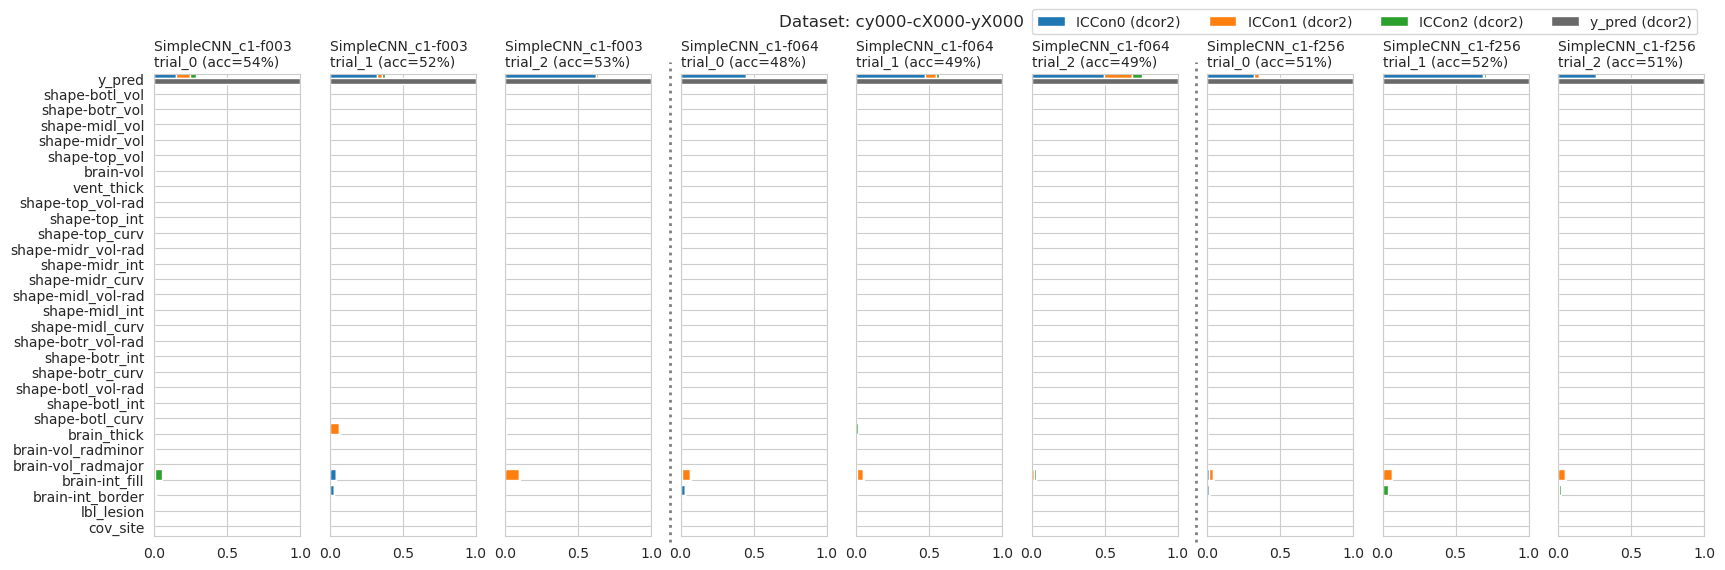

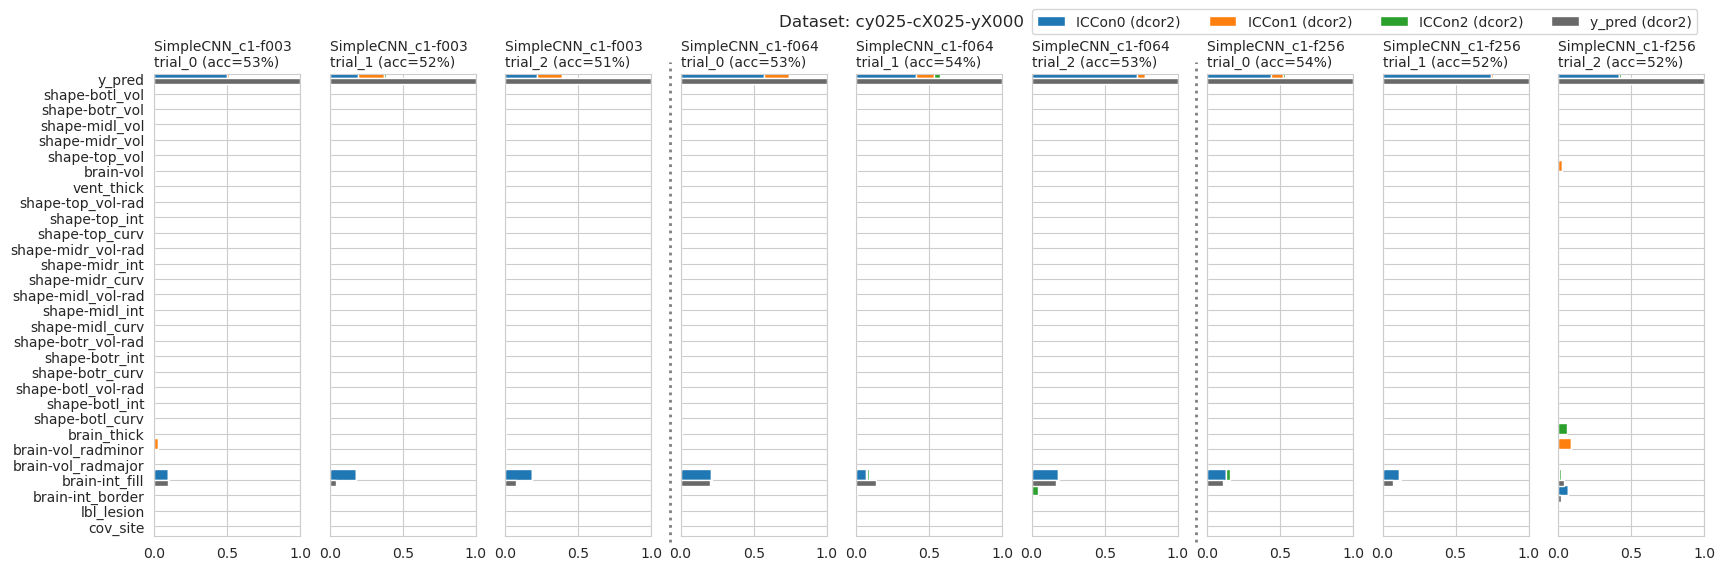

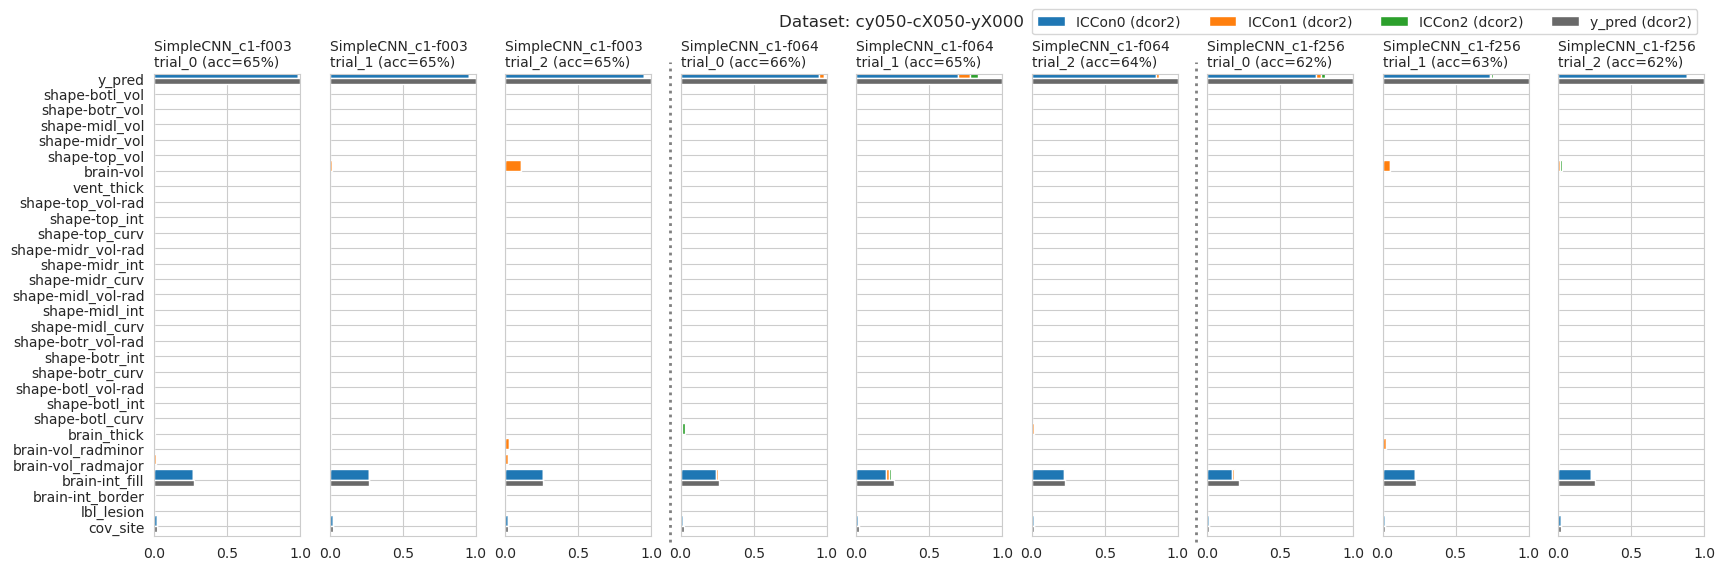

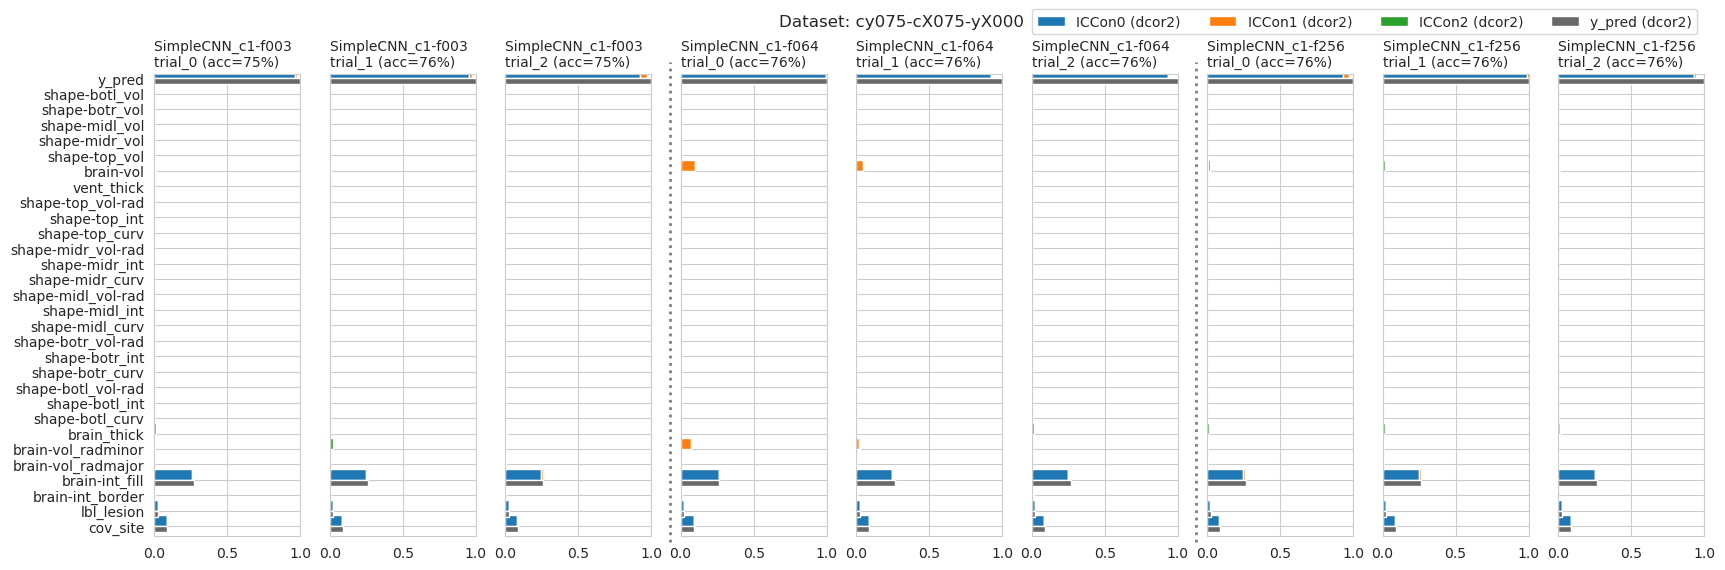

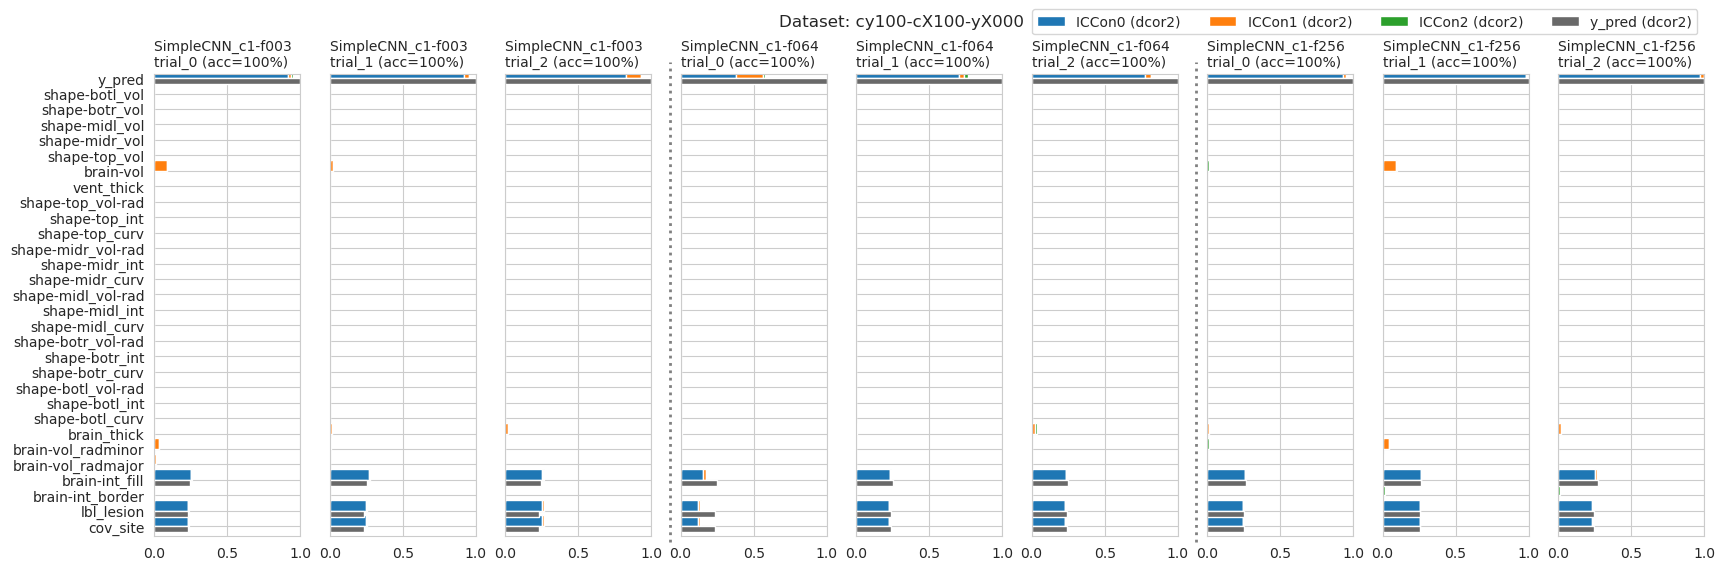

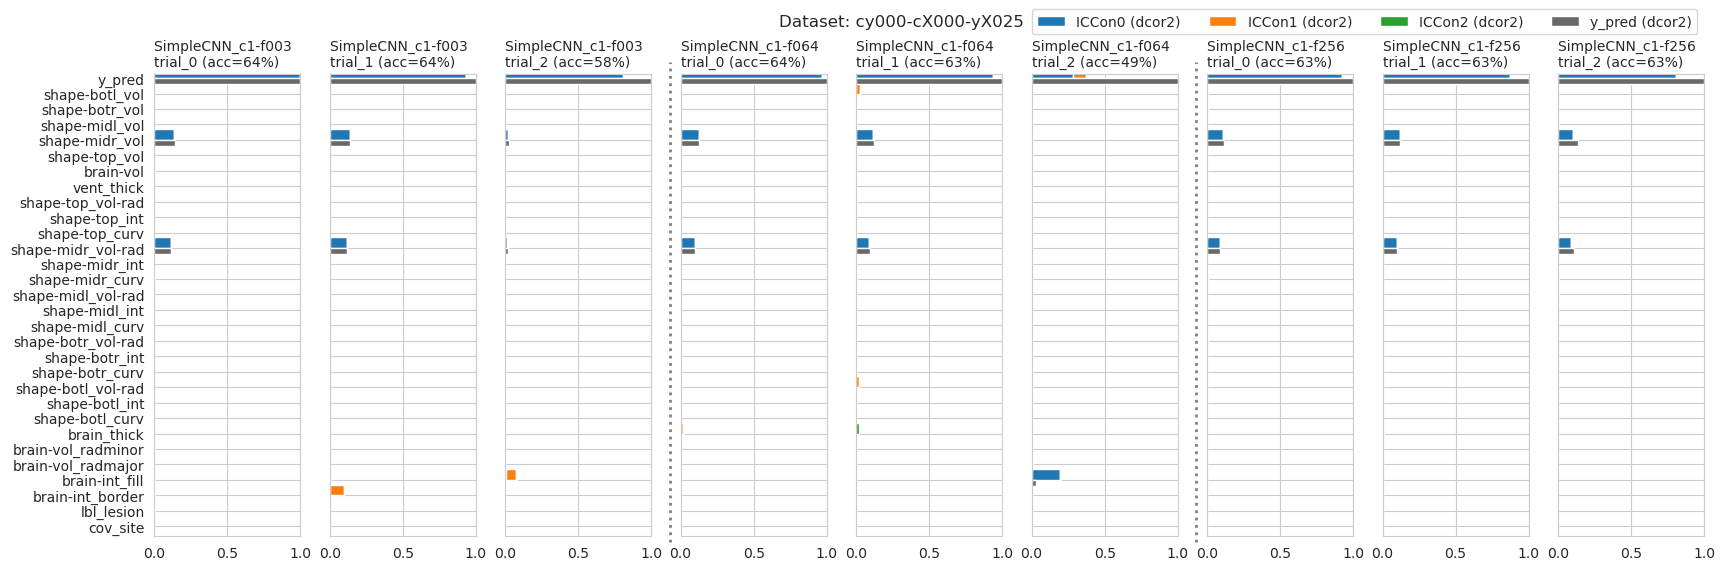

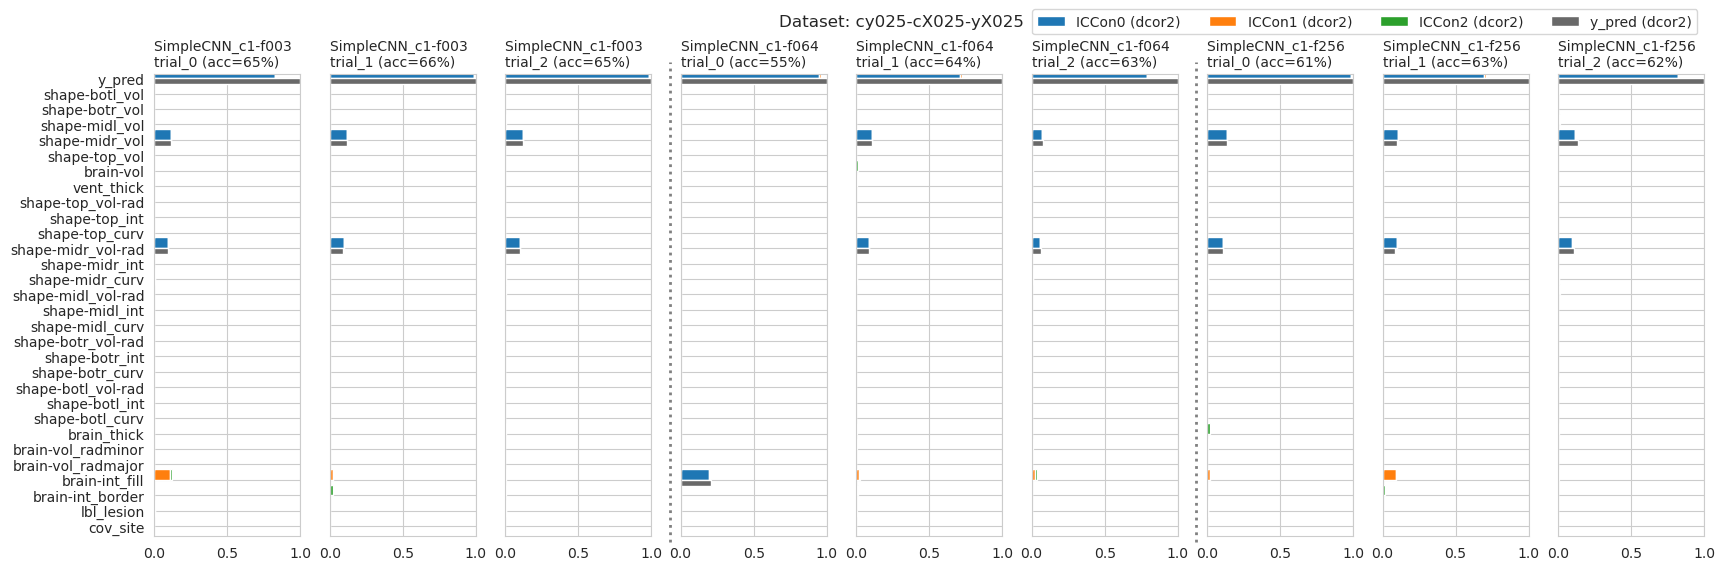

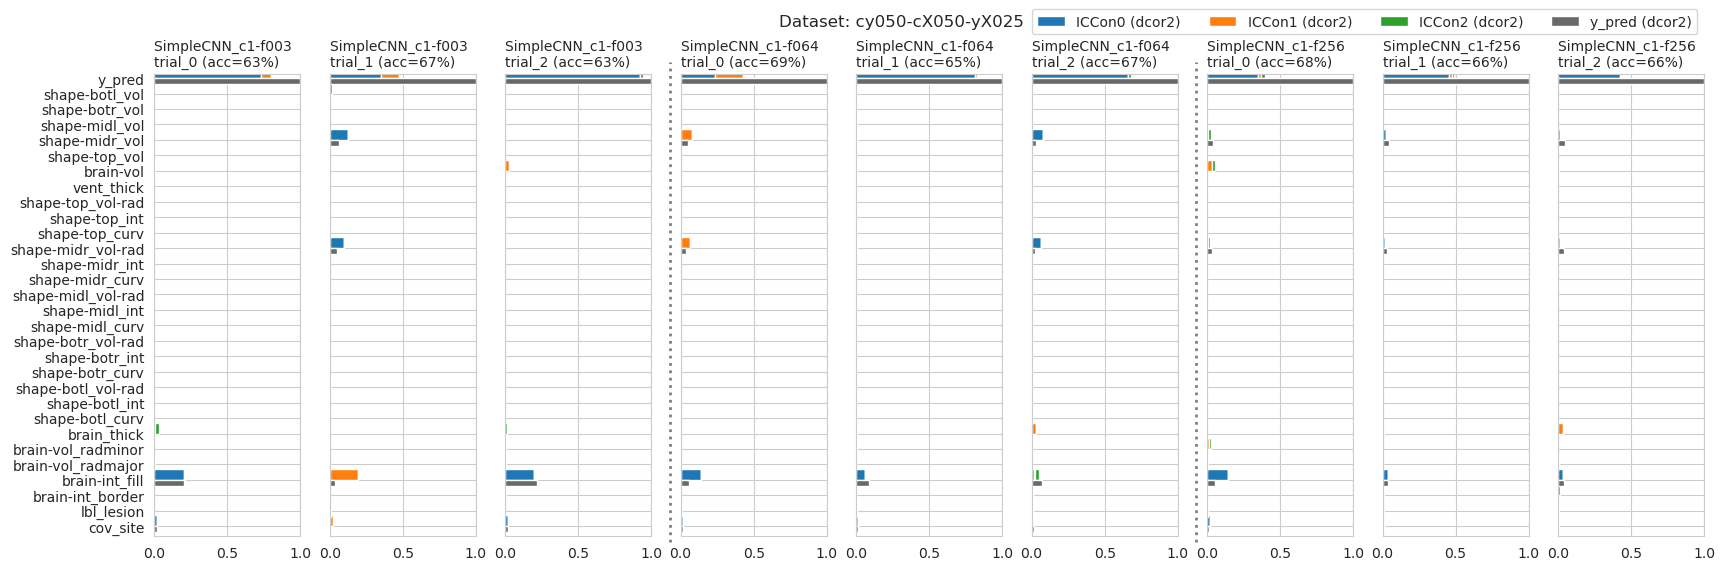

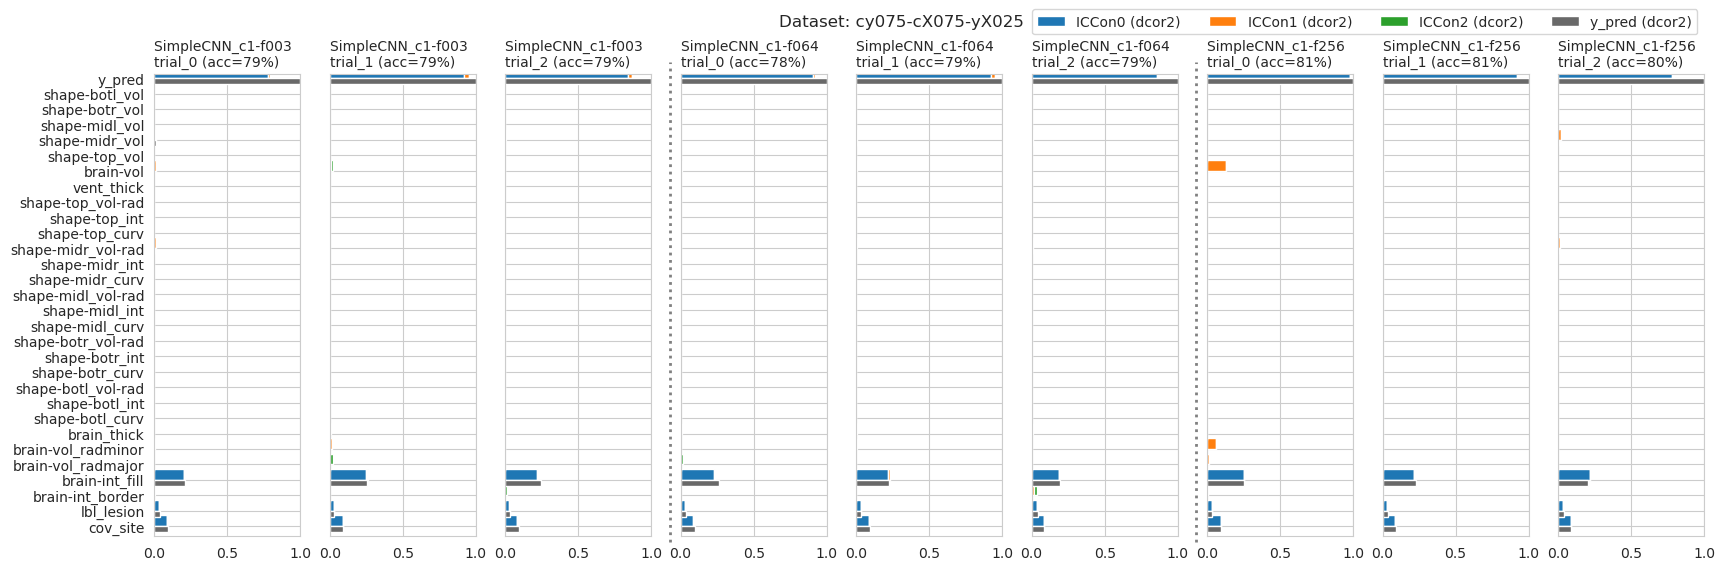

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


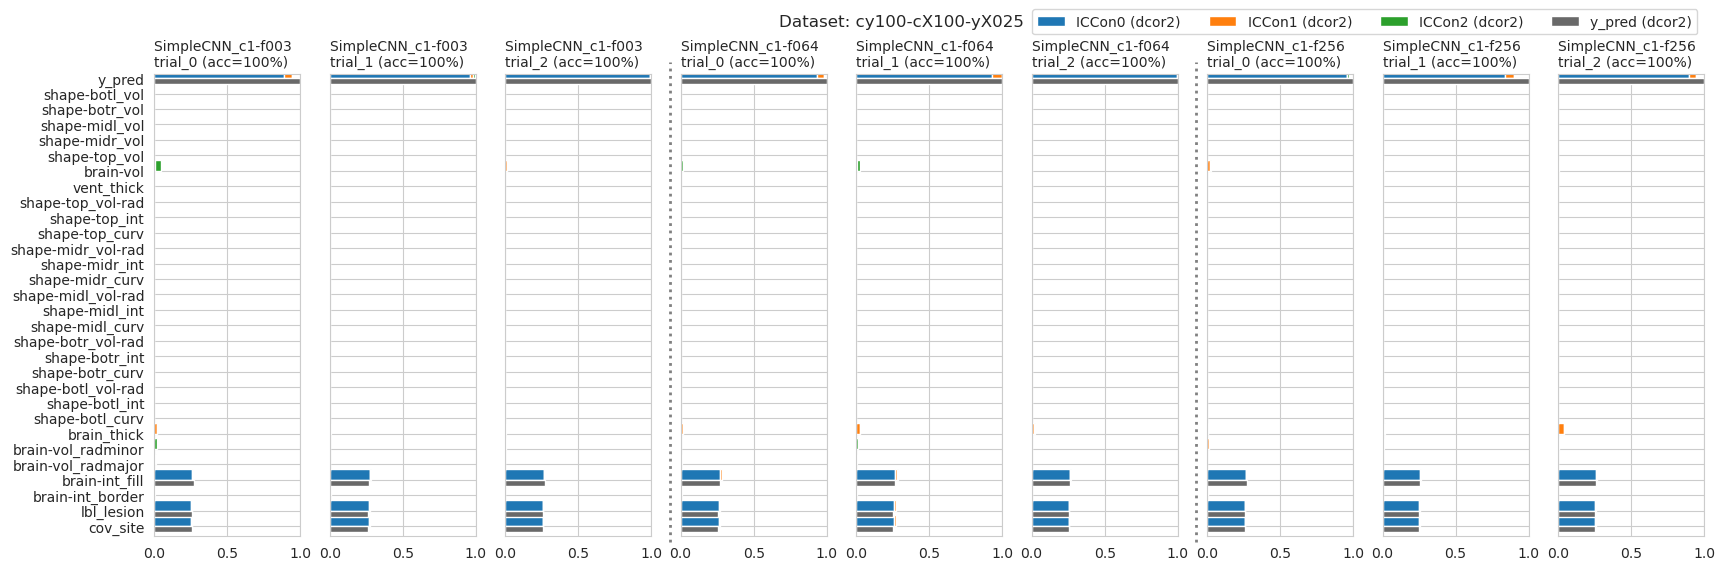

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


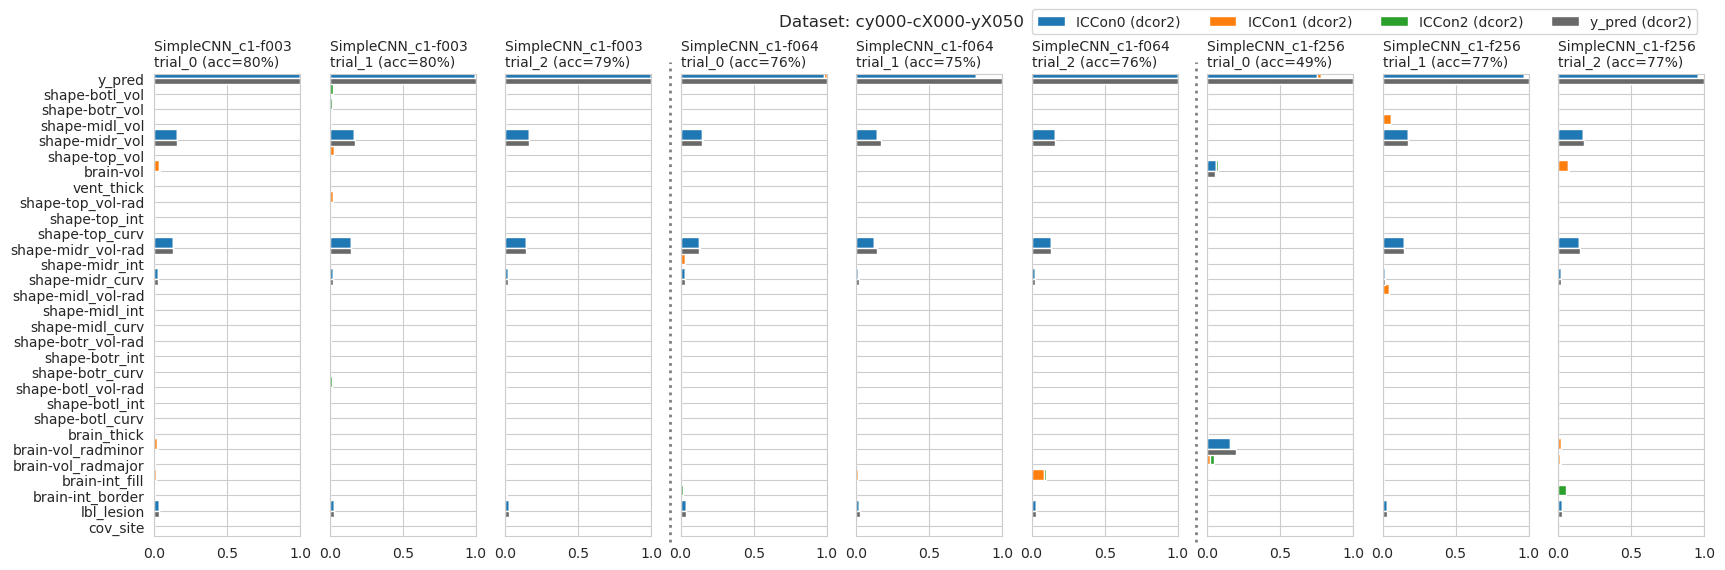

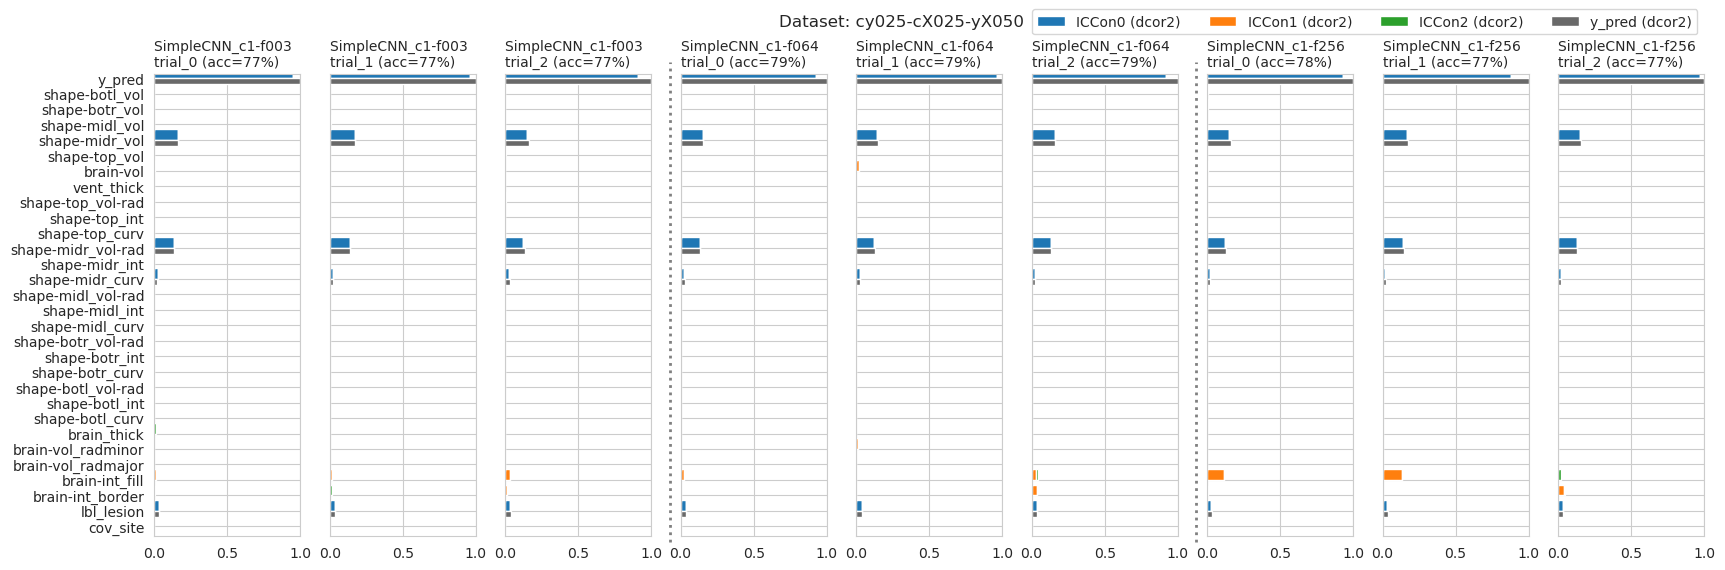

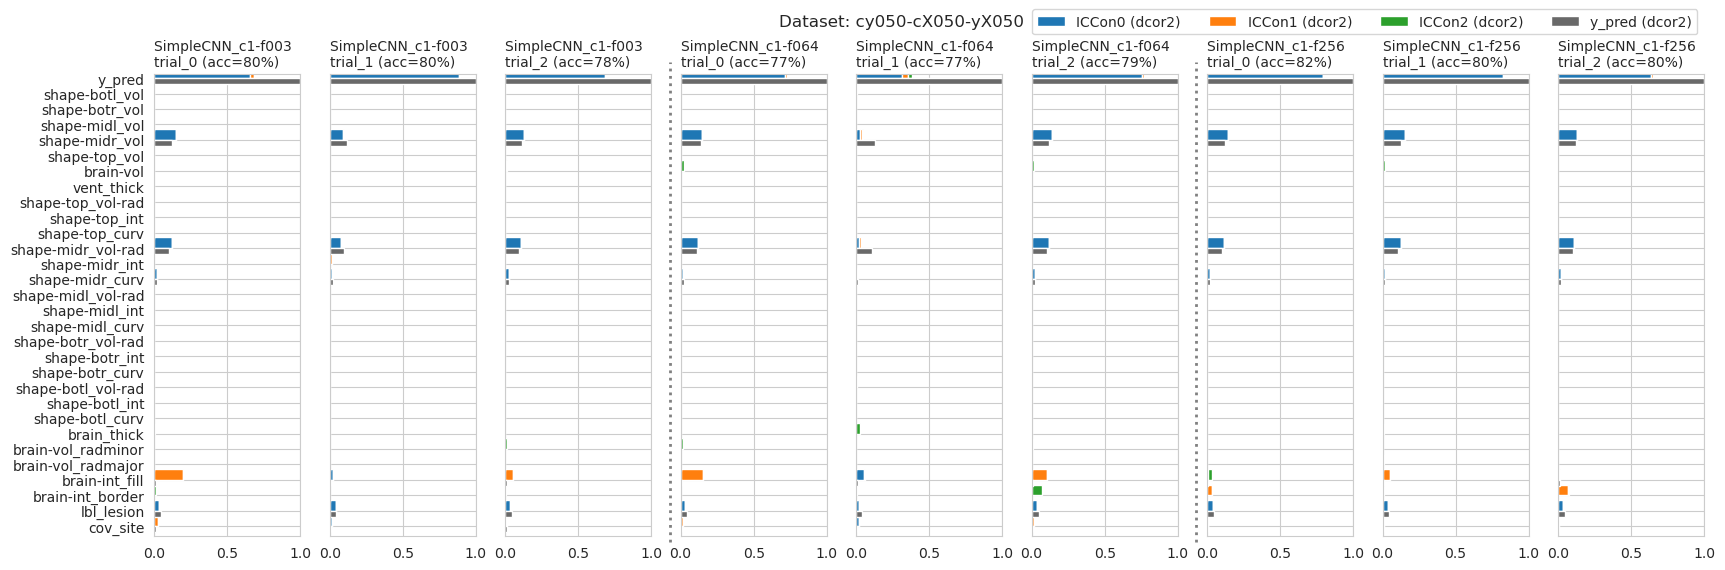

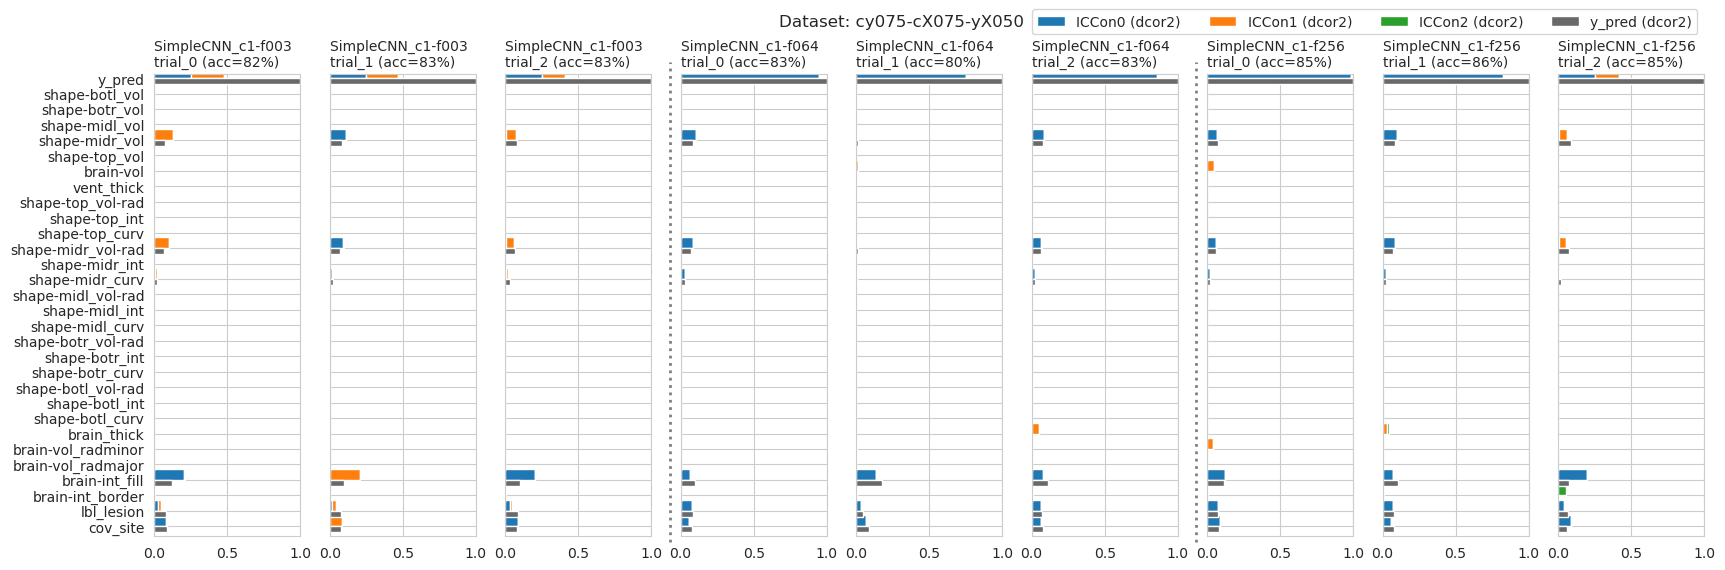

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


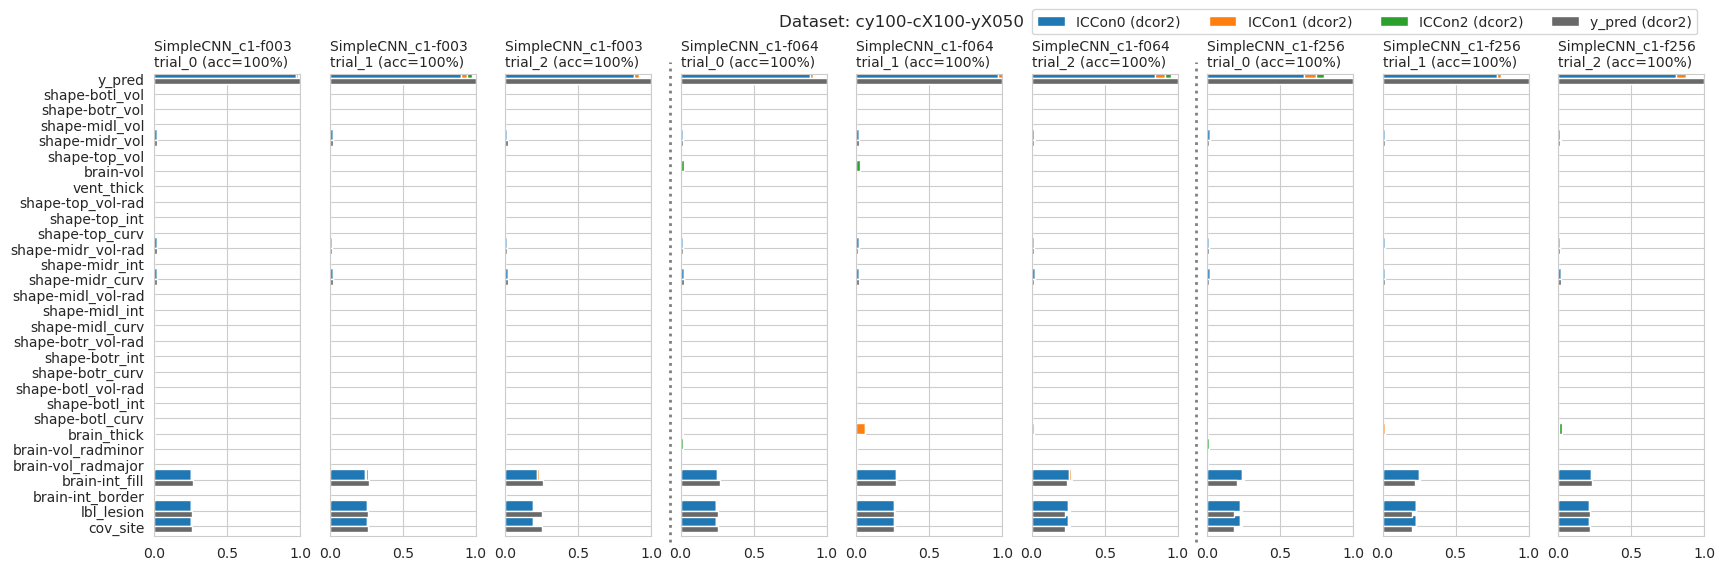

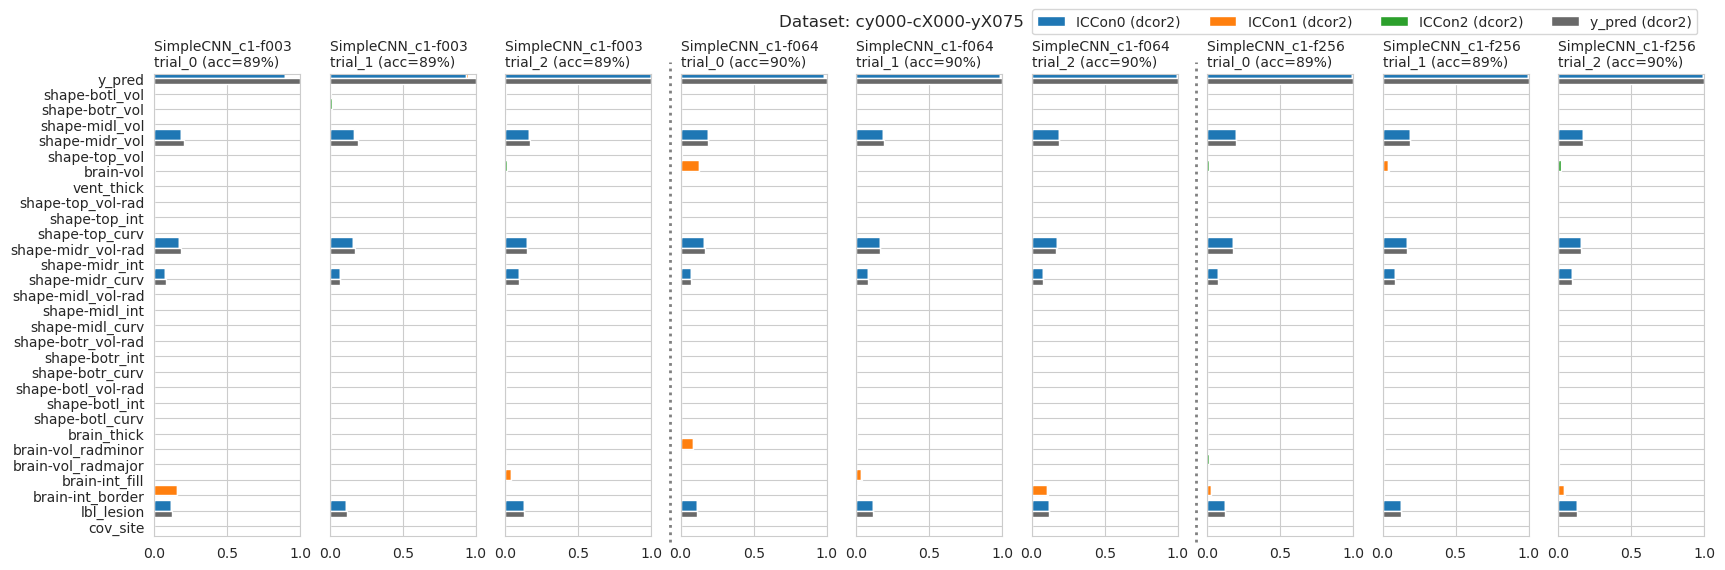

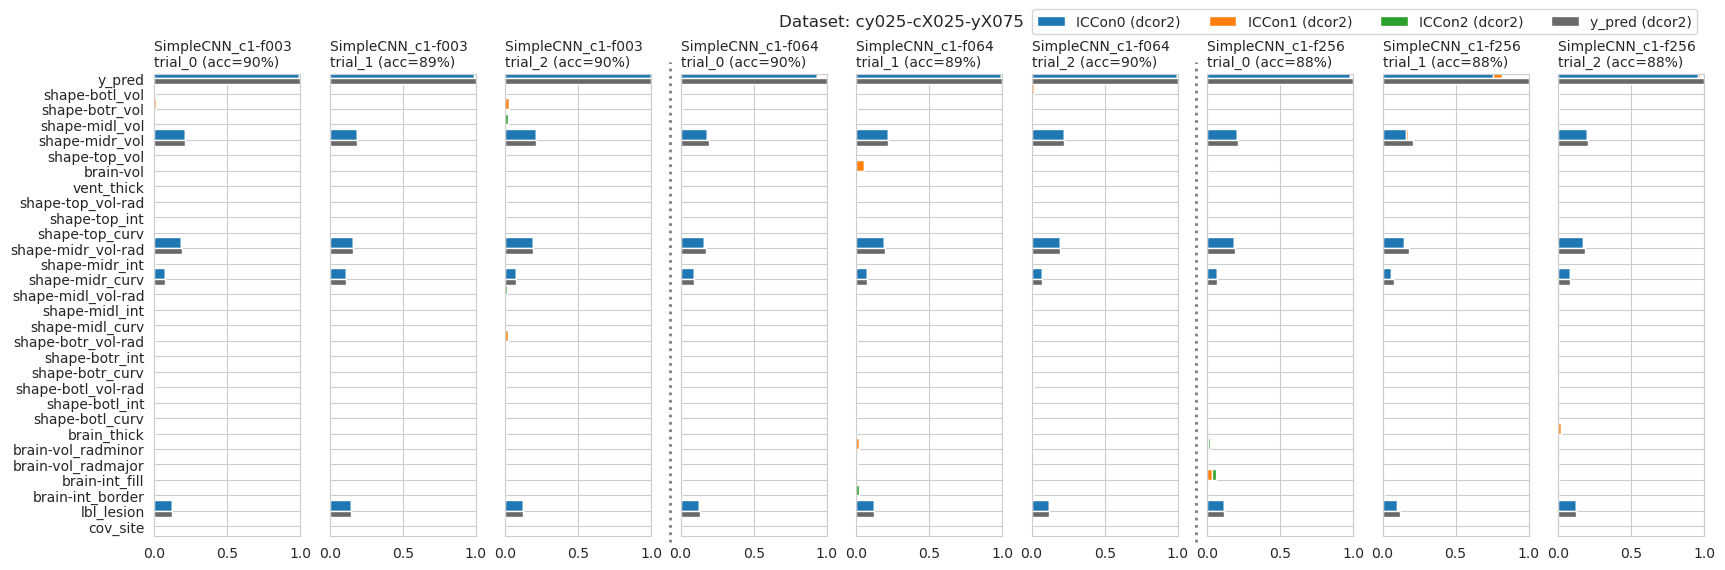

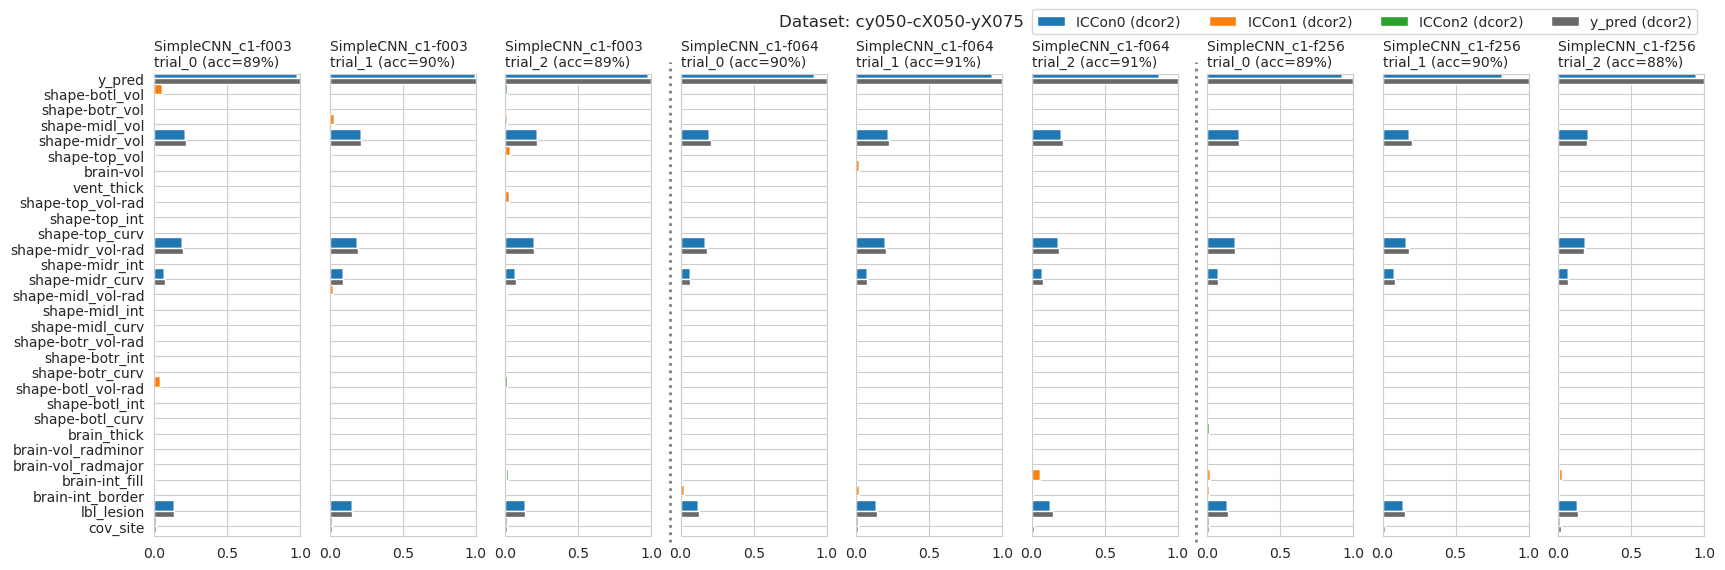

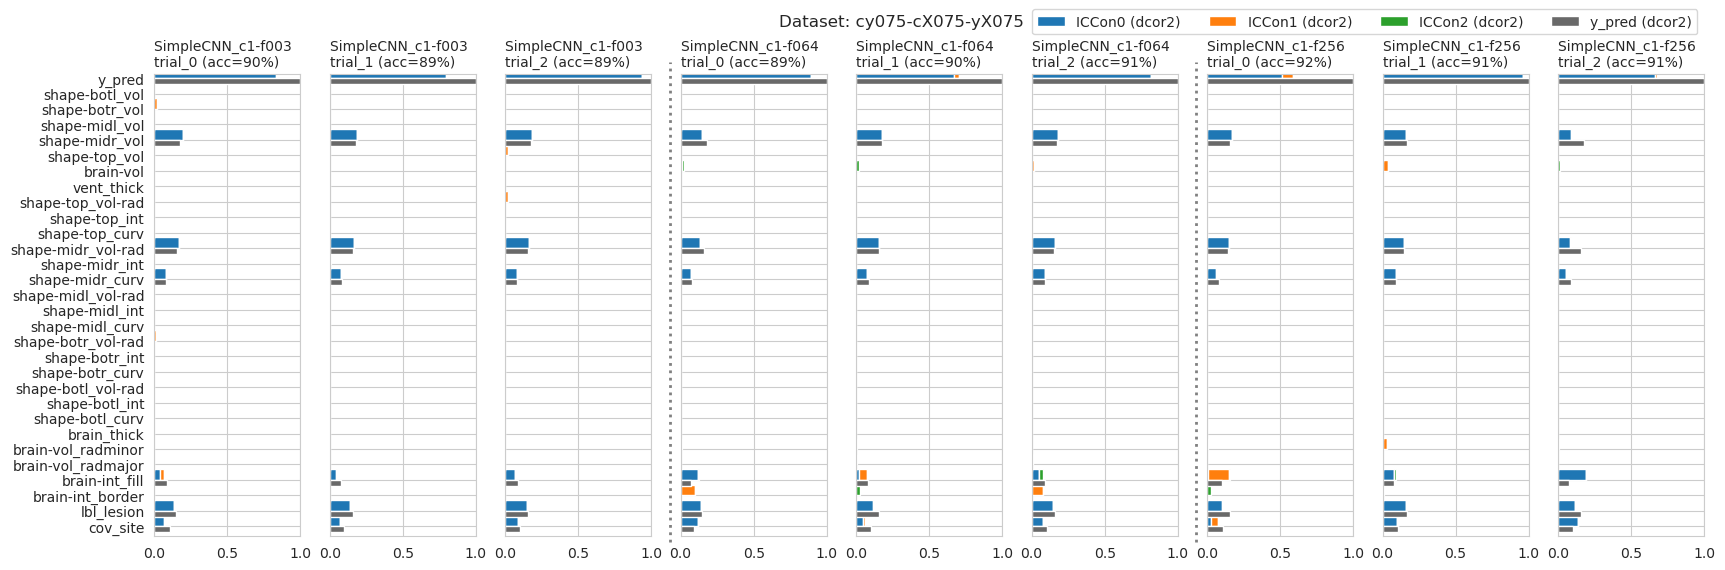

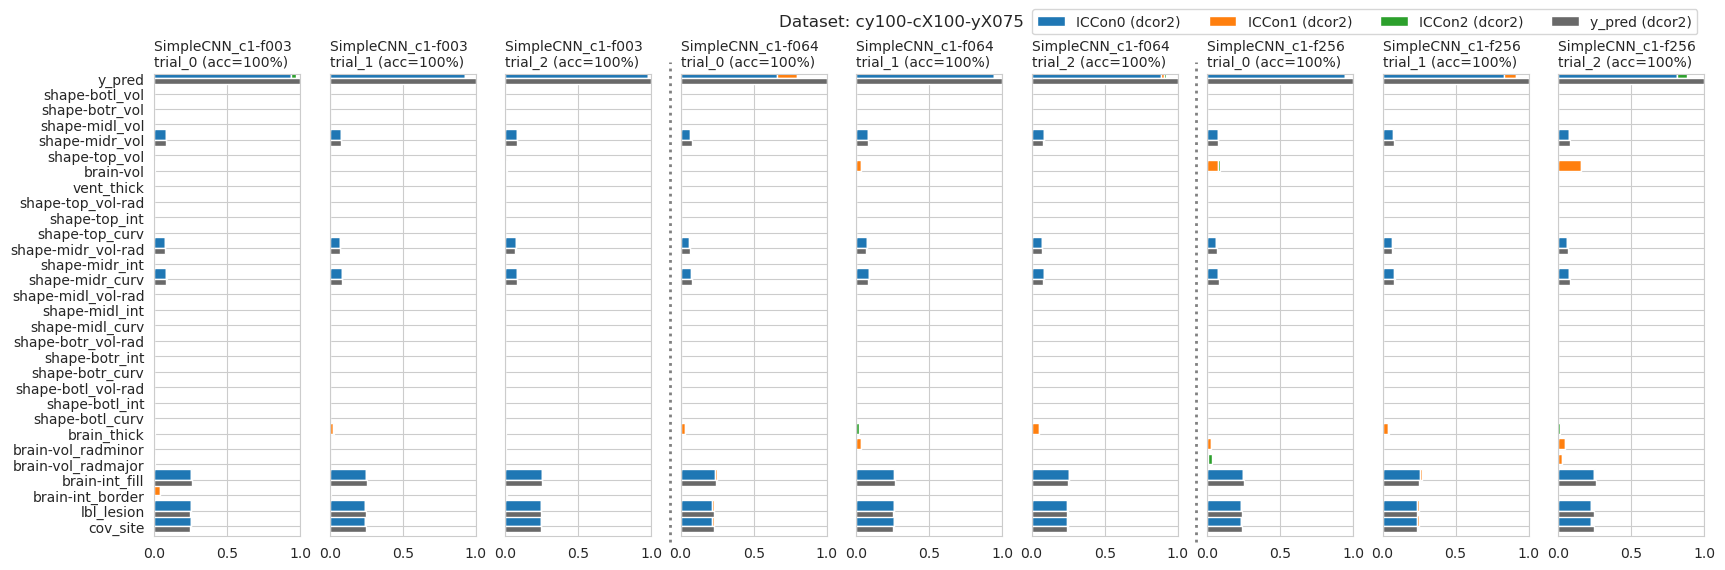

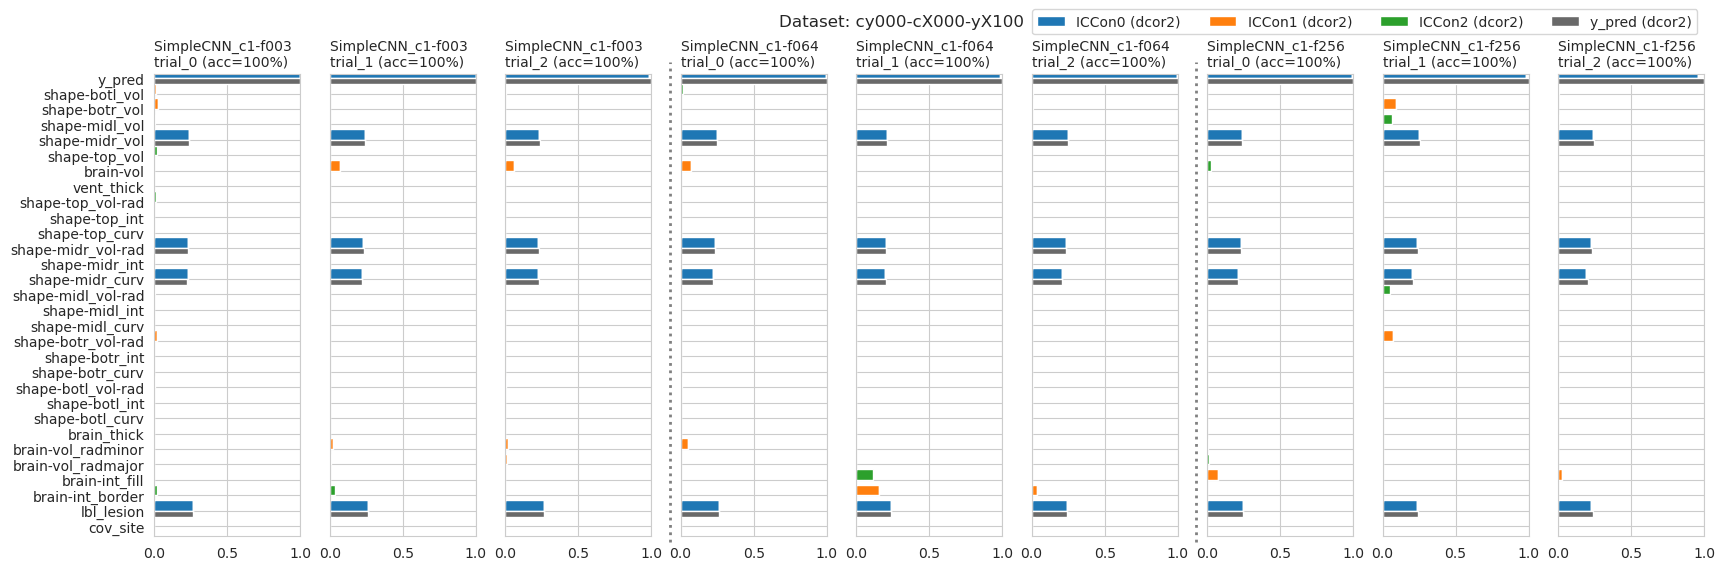

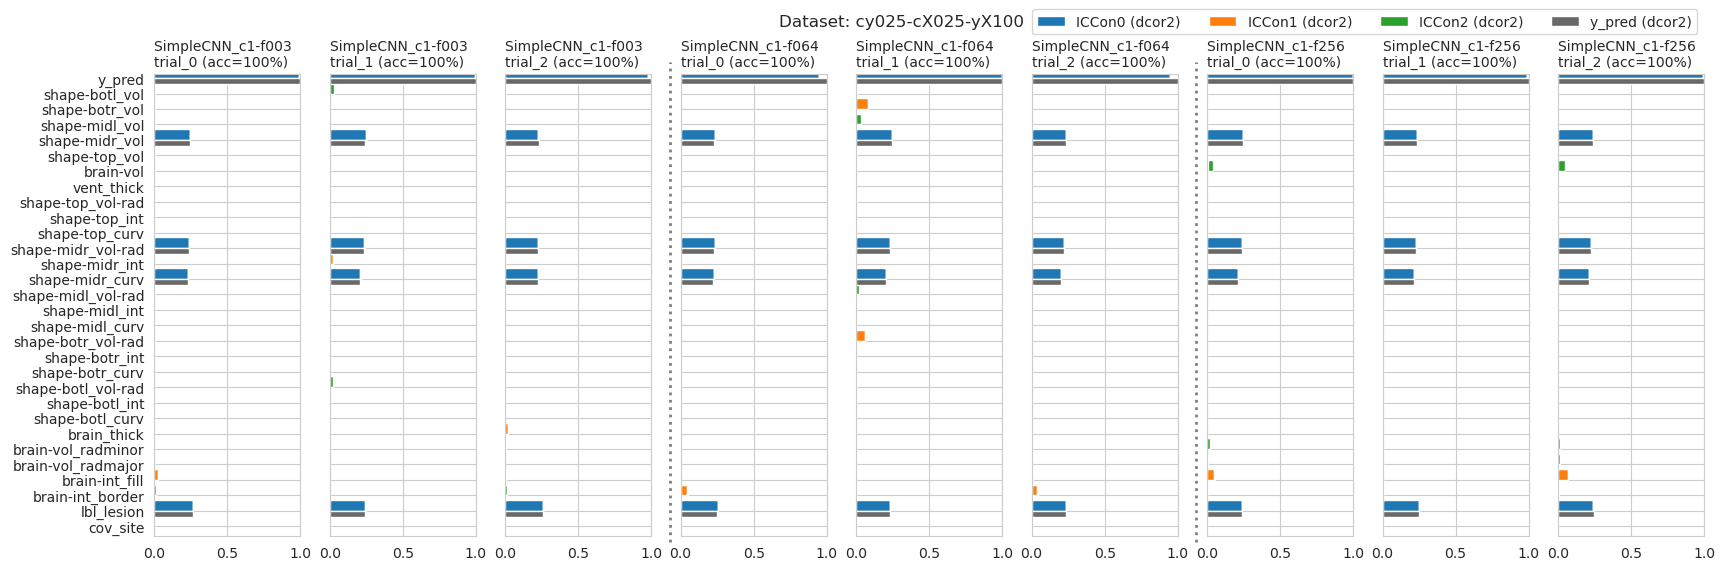

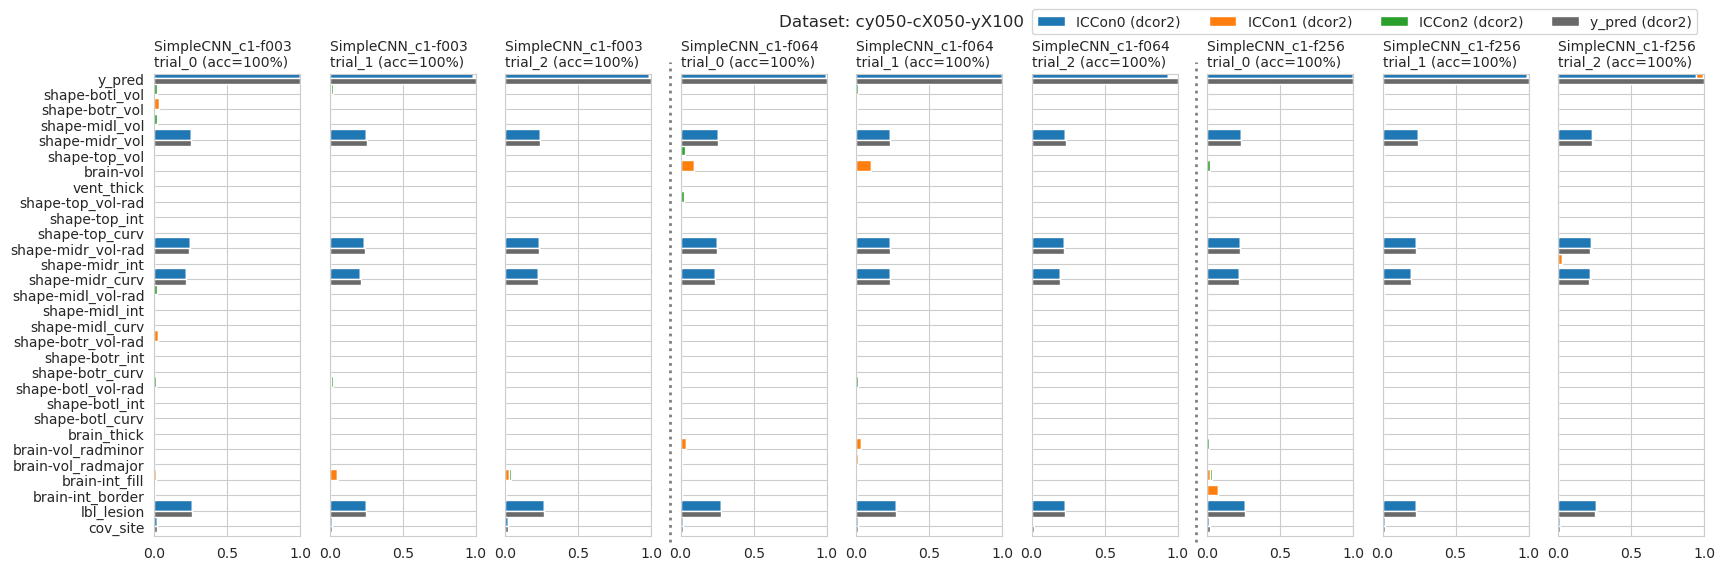

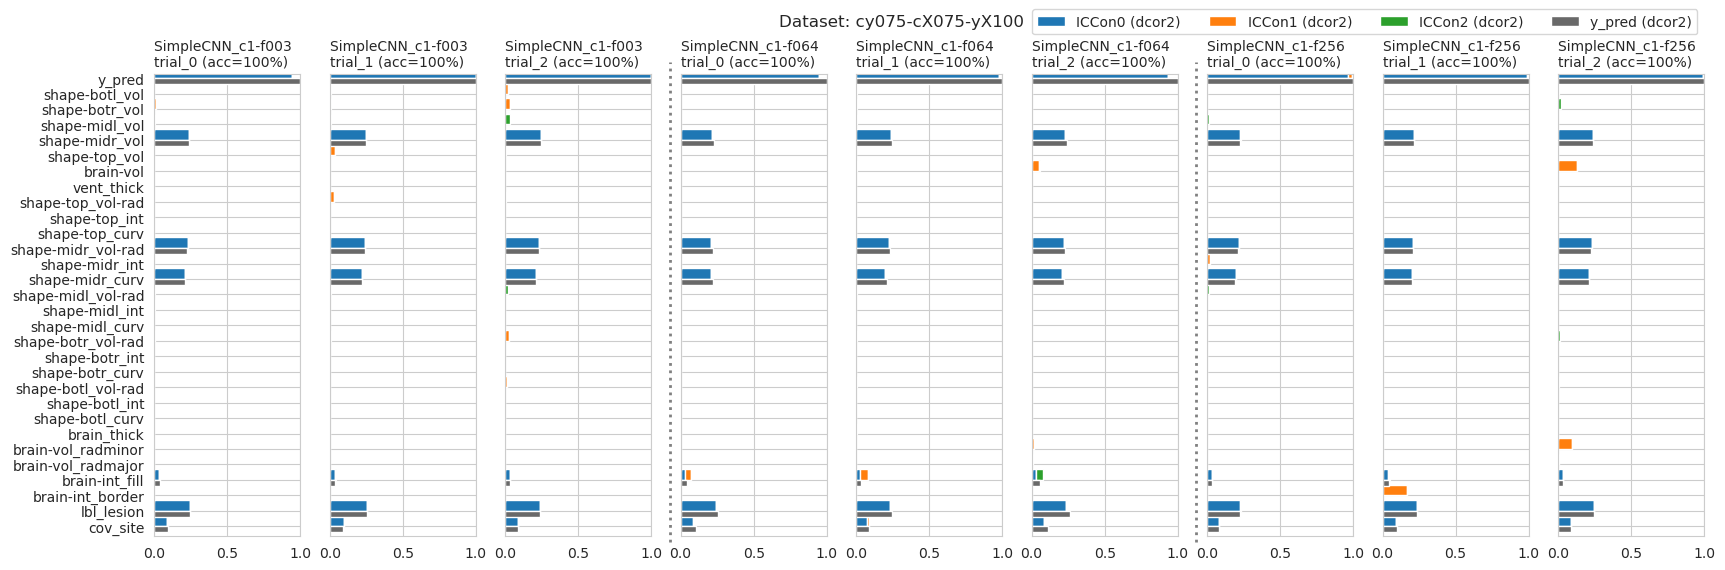

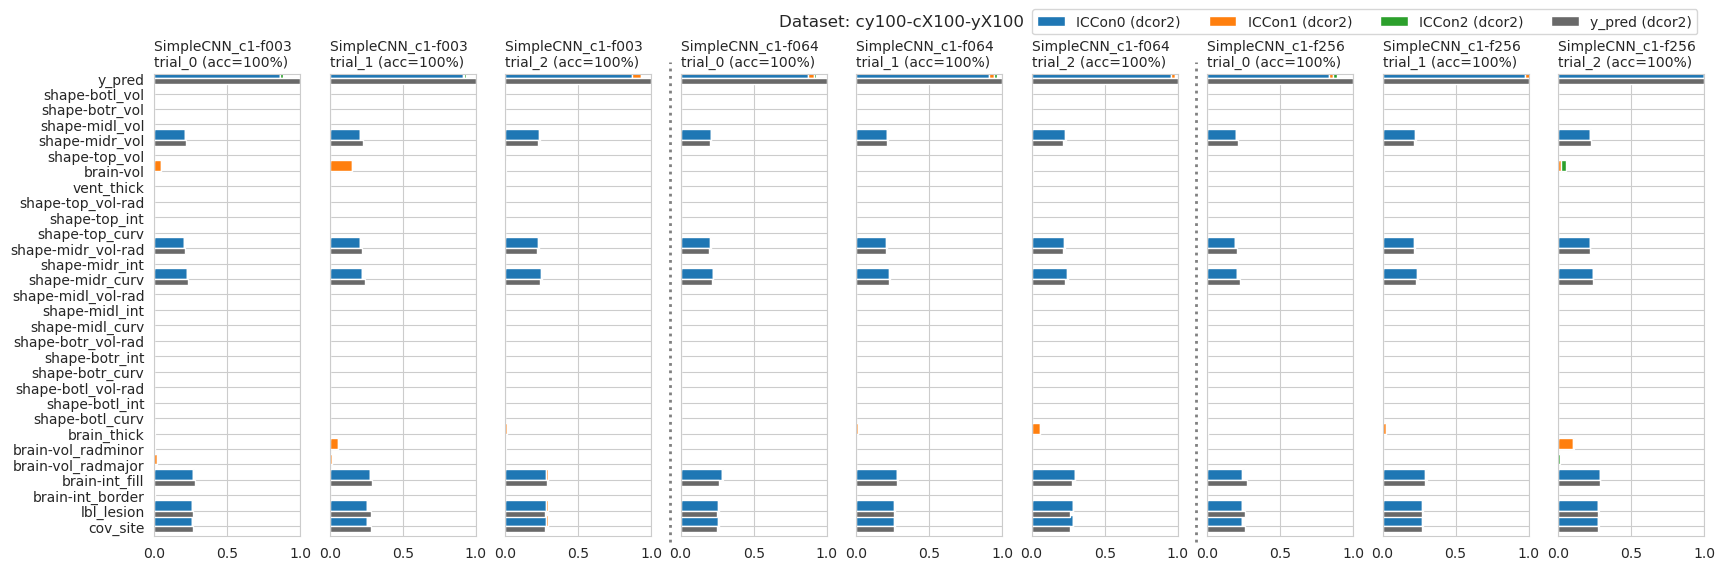

cov_site  \
dataset           model_name        trial   score                      
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 y_pred (dcor2)       0.0   
                                            ICCon1 (dcor2)       0.0   
                                            ICCon2 (dcor2)       0.0   
                                            ICCon0 (dcor2)       0.0   
                                    trial_1 y_pred (dcor2)       0.0   
...                                                              ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICCon0 (dcor2)  0.271193   
                                    trial_2 y_pred (dcor2)  0.275661   
                                            ICCon2 (dcor2)  0.003753   
                                            ICCon1 (dcor2)  0.000345   
                                            ICCon0 (dcor2)   0.27316   

                                                           lbl_lesion  \
dataset           model_name        trial   score                       
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 y_pred (dcor2)   0.000011   
                                            ICCon1 (dcor2)        0.0   
                                            ICCon2 (dcor2)        0.0   
                                            ICCon0 (dcor2)   0.000007   
                                    trial_1 y_pred (dcor2)   0.000009   
...                                                               ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICCon0 (dcor2)   0.271193   
                                    trial_2 y_pred (dcor2)   0.275661   
                                            ICCon2 (dcor2)   0.003753   
                                            ICCon1 (dcor2)   0.000345   
                                            ICCon0 (dcor2)    0.27316   

                                                           brain-int_border  \
dataset           model_name        trial   score                             
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 y_pred (dcor2)         0.000097   
                                            ICCon1 (dcor2)         0.007265   
                                            ICCon2 (dcor2)         0.000676   
                                            ICCon0 (dcor2)         0.004439   
                                    trial_1 y_pred (dcor2)          0.00661   
...                                                                     ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICCon0 (dcor2)              0.0   
                                    trial_2 y_pred (dcor2)              0.0   
                                            ICCon2 (dcor2)         0.001434   
                                            ICCon1 (dcor2)         0.000052   
                                            ICCon0 (dcor2)              0.0   

                                                           brain-int_fill  \
dataset           model_name        trial   score                           
cy000-cX000-yX000 SimpleCNN_c1-f003 trial_0 y_pred (dcor2)       0.008368   
                                            ICCon1 (dcor2)       0.001438   
                                            ICCon2 (dcor2)       0.047542   
                                            ICCon0 (dcor2)       0.001368   
                                    trial_1 y_pred (dcor2)       0.005217   
...                                                                   ...   
cy100-cX100-yX100 SimpleCNN_c1-f256 trial_1 ICCon0 (dcor2)       0.290965   
                                    trial_2 y_pred (dcor2)       0.288069   
                                            ICCon2 (dcor2)       0.004042   
                                            ICCon1 (dcor2)       0.000381   
                                            ICCon0 (dcor2)       0.286105   

                                                           brain-vol_radmajor  \
dataset           model_name        trial   score             

In [127]:
if RUN_ICCon:
    df_results_iccon = run_iccon(logs, 
                                n_comps=3, 
                                SHOW_RAW_PLOTS=True)
    display(df_results_iccon)

### Compare $ICCon_i$ with $A_{conf}$ 

In [186]:
# plot the datasets on the X-axis and the  D2(Aconf) and D2(Atrue) on the Y-axis as
def compare_score_with_true(df_scores, 
                            confounds=['brain-int_fill'], trues=['shape-midr_vol-rad'], 
                            df_model=df_results, model_metric='BAC_test', model_name_filter='.*'):

    ### (1) Clean and prepare the df with model accuracies across datasets
    # drop the indexes 'model_name' and 'trial' and only keep the 'dataset' as index 
    df = df_model.copy()
    # flatten the multi-index columns & select only the metric requested
    df = df.droplevel(level=0, axis='columns').filter(like=model_metric)
    # reorg the df with scores
    df_scores = df_scores.copy().reset_index().pivot(
        index=['dataset', 'model_name', 'trial'], columns=['score']).astype(float)

    ### (2) show the Atrue and Aconf results in 2 subplots and and show the
    # respective variable scores (confounds vs trues) in the subplot
    fig, axes = plt.subplots(2,1, figsize=(12, 8), 
                             sharex=True, sharey=True)
    axes = axes.flatten()

    ### (2a) first plot Atrue vs trues
    df_trues = pd.concat([df.filter(like='no-conf'), df_scores[trues]], axis=1)
    # drop the models not matching the model_name_filter and then drop the model_name and trial
    df_trues = df_trues[df_trues.index.get_level_values('model_name').str.match(model_name_filter)]
    unique_model_names = df_trues.index.get_level_values('model_name').unique().tolist()
    df_trues = df_trues.reset_index(level=['model_name', 'trial'], drop=True)
    # set different color for different attribute
    iccons_in_cols = list(df_trues.columns.str[-1])
    unique_iccon_colors = {a: sns.color_palette()[i] for i, a in enumerate(np.unique(iccons_in_cols))}
    color_palettes_list = [unique_iccon_colors[c] for c in iccons_in_cols]

    g = sns.lineplot(df_trues,
                     palette=color_palettes_list, err_style="bars", ax=axes[0])
    axes[0].set_title(f"Compare Aconf vs score for 'confound' variables for models {unique_model_names}")

    ### (2b) next plot Aconf vs confounds
    df_confs = pd.concat([df.filter(like='no-true'), 
                          df_scores[confounds]], axis=1)
    
    # drop the models not matching the model_name_filter and then drop the model_name and trial 
    df_confs = df_confs[df.index.get_level_values('model_name').str.match(model_name_filter)]
    df_confs = df_confs.reset_index(level=['model_name', 'trial'], drop=True)
    # set different color for different attribute
    iccons_in_cols = list(df_confs.columns.str[-1])
    unique_iccon_colors = {a: sns.color_palette()[i] for i, a in enumerate(np.unique(iccons_in_cols))}
    color_palettes_list = [unique_iccon_colors[c] for c in iccons_in_cols]

    g = sns.lineplot(df_confs, 
                     palette=color_palettes_list, 
                     err_style="bars", ax=axes[1]) # 
    axes[1].set_title(f"Compare Atrue vs score for 'signal' variables for models {unique_model_names}")

    ### (3) beautify the x axis and y axis
    # on the x-axis ticks show the total correlation X<-y and the total X<-c->y
    new_xticklabels = []
    majorticks = []
    last_Xy = -1
    last_Xcy = -1
    for lbl in axes[1].get_xticklabels():
        cy, cX, yX  = lbl.get_text().split('-')
        cy = int(cy[-3:])
        cX = int(cX[-3:])
        yX = int(yX[-3:])
        total_Xy = yX
        total_Xcy = (cX*cy)**(1/2)                

        if total_Xy != last_Xy:
            new_xticklabels.append(f'True={total_Xy:3.0f}%      Conf={total_Xcy:3.0f}%')
            last_Xy = total_Xy
            # add a major tick label every time the total_Xy changes
            majorticks.append(lbl.get_position()[0]-1)
        else:
            new_xticklabels.append(f'Conf={total_Xcy:3.0f}%')
        
    axes[1].xaxis.set_ticklabels(new_xticklabels, rotation=90)
    # vertical lines to show transition of X<-c->y
    for x_line in majorticks:
        if x_line>0:
            for ax in axes:
                ax.vlines(x_line, ax.get_ylim()[-1], -0.1, color='grey', ls='--', lw=1,
                        clip_on=False, transform=ax.get_xaxis_transform())

    axes[1].set_xlabel(r'Increasing confound signal [$X \leftarrow c \to y$]   &   True signal  [$X \leftarrow y$] ', fontsize=15)
    plt.tight_layout()
    plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


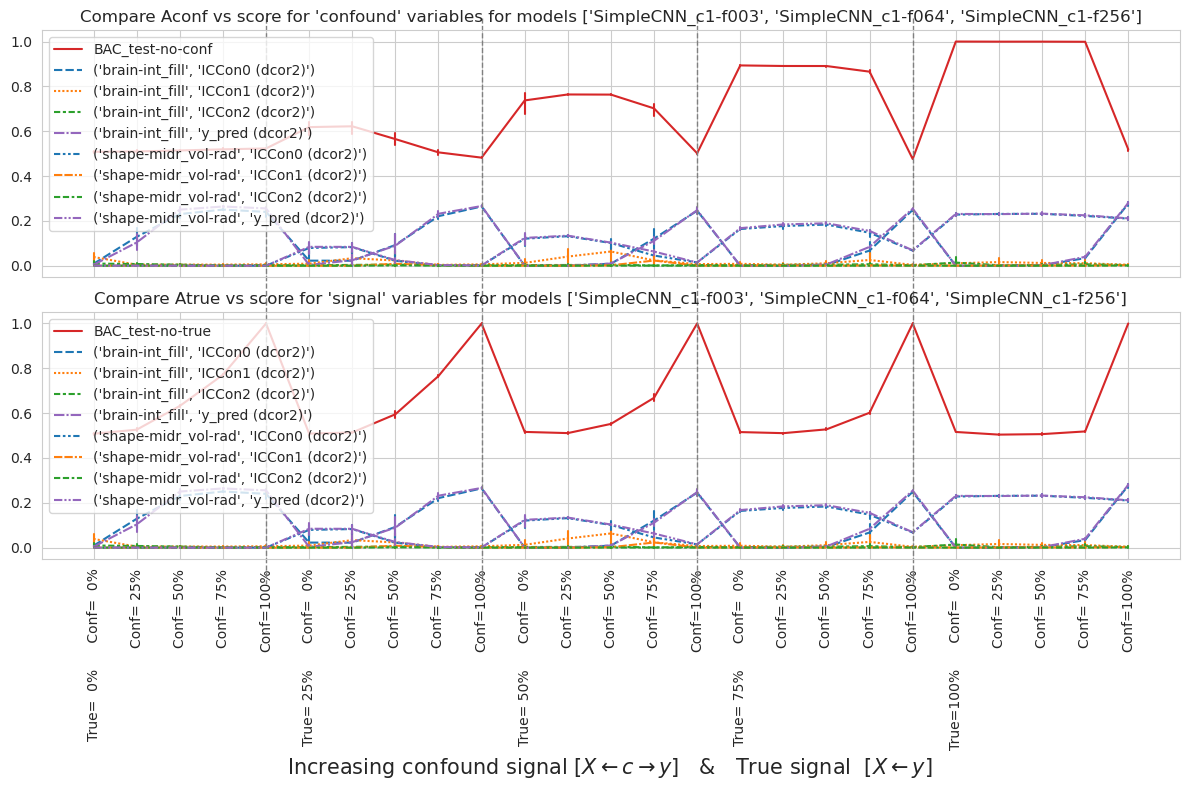

In [191]:
if RUN_ICCon:
    df_results_iccon_dcor2 = df_results_iccon.copy()
    compare_score_with_true(df_results_iccon_dcor2, 
                        confounds=['brain-int_fill', 'shape-midr_vol-rad'], trues=['brain-int_fill', 'shape-midr_vol-rad'], 
                        df_model=df_results, model_metric='BAC_test', model_name_filter='.*f256')

In [188]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif 

def compute_mi(X,y):
    if X.ndim==1:
        X = X.reshape(-1,1)
        
    y = y.values.reshape(-1,)
    assert X.shape[0]==y.shape[0], f"the shape of the activations and covariates should be (N, D) and (N, 1)\
 respectively but they are {X.shape} and {y.shape} respectively"
    
    # check if y is continuous or categorical variable
    if isinstance(y[0], (int, str)):
        mi_score = mutual_info_classif(X, y)
    else:
        mi_score = mutual_info_regression(X, y)
    return mi_score



In [192]:
if RUN_ICCon:
    df_results_iccon_mi = run_iccon(logs, 
                            n_comps=3, 
                            sim_metric={'mi': compute_mi}, 
                            SHOW_RAW_PLOTS=False)

  0%|          | 0/25 [00:00<?, ?it/s]

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


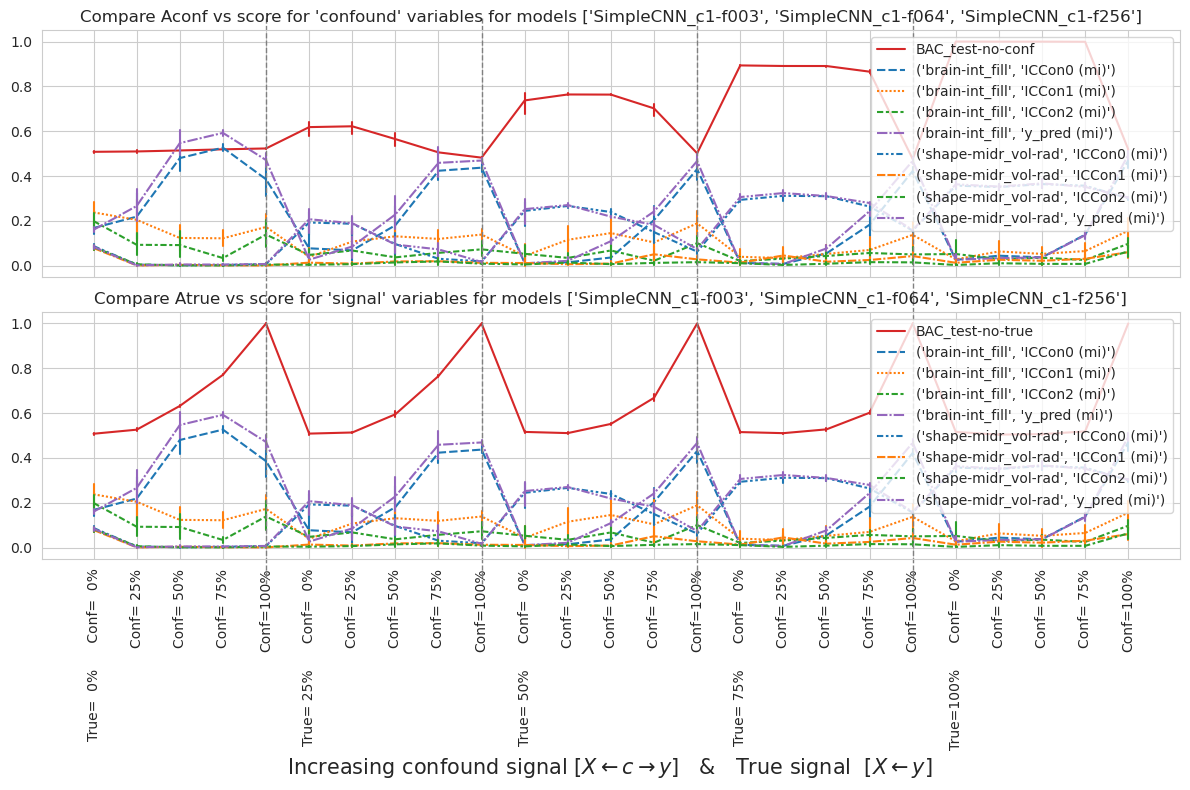

In [193]:
if RUN_ICCon:
    compare_score_with_true(df_results_iccon_mi, 
                        confounds=['brain-int_fill', 'shape-midr_vol-rad'], trues=['brain-int_fill', 'shape-midr_vol-rad'], 
                        df_model=df_results, model_metric='BAC_test', model_name_filter='.*')

### Visualize the ICCons
in the original representation space (for models with a 3D (l-1) layer)

In [ ]:
# for dataset in unique_datasets:
    
#     logs_3d = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))]

    # # create a 3D scatter plot of the activations
    # fig = plt.figure(figsize=plt.figaspect(1/len(logs_3d)))
    # fig.suptitle(f"Dataset: {dataset} \n", fontsize=12)

    # for i, (dataset, model_name, run, log) in enumerate(logs_3d):
    #     ax = fig.add_subplot(1, len(logs_3d), i+1, projection='3d')
    #     ax.scatter(log['act'][:,0], log['act'][:,1], log['act'][:,2], 
    #             c=log['y_pred'], cmap='coolwarm')
        
    # plt.show()
    # Import dependencies

In [ ]:
# import plotly
# import plotly.graph_objs as go
# import plotly.figure_factory as ff

# # Configure Plotly to be rendered inline in the notebook.
# plotly.offline.init_notebook_mode()

# ## (1) select a specfic dataset and run
# dataset_idx = 10
# run_idx = 2
# dataset = unique_datasets[dataset_idx]
# log_set = [log for log in logs if ((log[0]==dataset) and ('-f003' in log[1]))][run_idx]

# (dataset, model_name, run, log) = log_set

# print(f"{'-'*100} \nDataset: {dataset} \t Model: {model_name} \t Run: {run}")

# # first get the attributes table for y
# df_attrs = pd.read_csv(f"dataset/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}/toybrains_n{N_SAMPLES}_{EXP_NAME}_{dataset}.csv")
# # make the table values numerical using the DeepRepVizBackend
# drv = DeepRepVizBackend(conf_table=df_attrs, 
#                         ID_col='subjectID', label_col='lbl_lesion', 
#                         best_ckpt_by="test_loss")
# # reorder to match the IDs of the model results and the confound table
# df_attrs = drv.df_conf.loc[log['IDs']]

# ## (2) create a 3D scatter plot of the activations
# # Color points by confounder
# color_by = 'brain-int_fill'
# hover_by = ['brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']
# hover_text = [f"{'<br>'.join([f'{k}: {v}' for k,v in row.items()])}" for i, row in df_attrs[hover_by].iterrows()]

# # hover_text = [f"y_pred={y_pred:.2f}  |  {hover_text}" for y_pred, attr in zip(log['y_pred'], hover_text)]
# fig = go.Figure(go.Scatter3d(
#     x=log['act'][:,0], y=log['act'][:,1], z=log['act'][:,2],
#     mode='markers',
#     marker={'size':3, 'opacity': 0.3, 'color':df_attrs[color_by]},
#     name=f'H(l-1) Activations colored by {color_by}', 
#     hovertext=hover_text,
# ))


# ## (3) put the y_pred weights as a vector on the plot
# wgt_pt = log['y_pred_weights']
# wgt_pt /= np.linalg.norm(wgt_pt) # normalize it
# y_pred_color = 'rgb(30,10,0)'
# # draw a line that extends in the directions by the weight vector, scaled by the std. dev. of the points
# std_ext = 3*log['act'].std(axis=0).max()
# # avg_pt = log['act'].mean(axis=0)
# fig.add_trace(go.Scatter3d( 
#                        x=[-wgt_pt[0]*std_ext, wgt_pt[0]*std_ext],
#                        y=[-wgt_pt[1]*std_ext, wgt_pt[1]*std_ext], 
#                        z=[-wgt_pt[2]*std_ext, wgt_pt[2]*std_ext],
#                        marker = dict(size=1, color=y_pred_color),
#                        line = dict(color=y_pred_color, width=4),
#                        name=f'y_pred ({log["test_acc"]*100:.0f}% Acc)'
#                      ))


# ## (4) draw the PCAs
# n_components=3
# X_pca, pca = compute_pca(log['act'], n_components=n_components)
# pca_color = 'rgb(200,50,0)'
# for i in range(n_components):
#     pca_pt = pca.components_[i]
#     pca_pt /= np.linalg.norm(pca_pt) # normalize it 
#     pca_pt = pca_pt * pca.explained_variance_[i] # scale by its variance explained
#     fig.add_trace(go.Scatter3d(
#         x=[0, pca_pt[0]*std_ext],
#         y=[0, pca_pt[1]*std_ext],
#         z=[0, pca_pt[2]*std_ext],
#         marker = dict(size=1, color=pca_color),
#         line = dict(color=pca_color, width=2),
#         visible ='legendonly',
#         name=f'PCA{i} (R2={pca.explained_variance_ratio_[i]*100:.0f}%)'
#     ))


# ## (4) draw the ICAs
# X_ica, ica = compute_ica(log['act'], n_components=n_components)
# ica_color = 'rgb(0,50,200)'
# for i in range(n_components):
#     ica_pt = ica.components_[i]
#     ica_pt /= np.linalg.norm(ica_pt) # normalize it
#     fig.add_trace(go.Scatter3d(
#         x=[0, ica_pt[0]*std_ext],
#         y=[0, ica_pt[1]*std_ext],
#         z=[0, ica_pt[2]*std_ext],
#         marker = dict(size=1, color=ica_color),
#         line = dict(color=ica_color, width=2),
#         visible ='legendonly',
#         name=f'ICA{i}'
#     ))


# ## (5) draw the ICCons
# X_ICCons, (pls, ica) = compute_pls_ica(log['act'], y=df_attrs, n_components=n_components)
# ## (5a) plot the PLS transform vectors
# ICCon_pls_color = 'rgb(0,250,50)'
# for i in range(n_components):
#     pls_pt = pls.x_loadings_.T[i]
#     pls_pt /= np.linalg.norm(pls_pt) # normalize it
#     fig.add_trace(go.Scatter3d(
#         x=[0, pls_pt[0]*std_ext],
#         y=[0, pls_pt[1]*std_ext],
#         z=[0, pls_pt[2]*std_ext],
#         marker = dict(size=1, color=ICCon_pls_color),
#         line = dict(color=ICCon_pls_color, width=2),
#         visible ='legendonly',
#         name=f'PLS{i}'
#     ))
# ## (5b) plot the PLS+ICA transform vectors
# ICCon_color = 'rgb(0, 100, 50)'
# iccon_components = (pls.x_weights_ * ica.components_.T).T
# for i in range(n_components):
#     iccon_pt = iccon_components[i]
#     iccon_pt /= np.linalg.norm(iccon_pt) # normalize it
#     fig.add_trace(go.Scatter3d(
#         x=[0, iccon_pt[0]*std_ext],
#         y=[0, iccon_pt[1]*std_ext],
#         z=[0, iccon_pt[2]*std_ext],
#         marker = dict(size=1, color=ICCon_color),
#         line = dict(color=ICCon_color, width=2),
#         visible =True,
#         name=f'ICCon{i}'
#     ))

# ### (-1) Render the plot.
# fig.update_layout(
#     # scene=dict(camera_eye=dict(x=0.05, y=-2.6, z=2)),
#                   margin=dict(t=0, b=0, l=0, r=0))
# plotly.offline.iplot(fig)

In [ ]:
# hover_by
# hover_text = [f"{'<br>'.join([f'{k}: {v}' for k,v in row.items()])}" for i, row in df_attrs[hover_by].iterrows()]
# hover_text

### Understanding Canonical correlation 

What is the relation between
1. `x_weights_`
2. `x_loadings_`
3. `x_rotations_`


In [ ]:
# MATS = [(pls.x_weights_, 'W'), 
#         (pls.x_loadings_, 'L'),
#         (pls.x_rotations_, 'R')]

# for mat, name in MATS:
#         print(f"{name} matrix \t shape (n_features, n_components): {mat.shape}")
#         display(mat)

In [ ]:
# for mat_i, name_i in MATS:
#     for mat_j, name_j in MATS:
#         if name_i==name_j: continue
#         print(f"{name_i} - {name_j}")
#         print(np.round(mat_i - mat_j, 3))

In [ ]:
# x_wgts, y_wgts = pls.transform(np.identity(log['act'].shape[-1]), 
#                                np.identity(df_attrs.shape[-1]))
# x_wgts.shape, y_wgts.shape


Findings:
1. $L'.R = I $
2. 

In [ ]:
np.eye(*log['act'].shape)

In [ ]:
x_wgts[:20]

In [ ]:
x_wgts[:20]

In [ ]:
x_wgts[:20]

In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSCanonical
import matplotlib.pyplot as plt

# Generate random variables X and Y
n = 1000
X = np.random.randn(n, 2)
Y =  2*X[:,0] + X[:,0]*X[:,1] + np.random.randint(0, 2, n)
Y = (Y - np.mean(Y))/np.std(Y)

# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='bwr')

# Add labels and title
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of X with Colored Points')
import matplotlib.pyplot as plt

# Compute PCA
mean_X = np.mean(X, axis=0)
centered_X = X - mean_X
cov_X = np.cov(centered_X.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_X)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Plot PCA components as vectors
for i in range(2):
    plt.arrow(mean_X[0], mean_X[1], 
              sorted_eigenvectors[0, i] * sorted_eigenvalues[i], sorted_eigenvectors[1, i] * sorted_eigenvalues[i], 
              color='r', width=0.1,
              label=f"PCA{i}")
import matplotlib.pyplot as plt
# Assuming X and Y are already defined

# Create an instance of PLSCanonical
pls = PLSCanonical(n_components=1)

# Fit the model to X and Y
pls.fit(X, Y)

# Get the canonical components
# X_canonical = pls.x_scores_
# Y_canonical = pls.y_scores_

# Plot the scatterplot
# plt.scatter(X_canonical[:, 0], X_canonical[:, 1], label='X')
# plt.scatter(Y_canonical[:, 0], Y_canonical[:, 1], label='Y')

# Plot the vectors
for i in range(pls.n_components):
    plt.arrow(0, 0, pls.x_loadings_[0,0], pls.x_loadings_[1,0], color='b', width=0.1,
              label="CCA")

plt.legend()

# Show the plot
plt.show()
